In [1]:
import localcider
from localcider.sequenceParameters import SequenceParameters
import protfasta
import glob
import pandas as pd
import numpy as np
import re
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict 
from Bio.Seq import Seq
import Bio
import matplotlib.patches as mpatches
import seaborn as sns
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
import editdistance
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import YeastAnalysisfunctions as YAF

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['pdf.fonttype'] = 42

# alignment distance vs activity difference 
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import time

In [2]:
# masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20210128_withSeqFeatures.csv')
masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20230414_withSeqFeatures.csv')
masterDF = pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20240930_withSeqFeatures.csv')

Activity = 'Activity_SCglucose'
maxActivity = max(masterDF[Activity])
minActivity = min(masterDF[Activity])
print('%i of %i Designed ADs recovered, %.1f percent'%(sum(masterDF['Recovered']),len(masterDF),100.0*sum(masterDF['Recovered'])/len(masterDF)))


# ActivityThresh = 100000
# HighActivityThresh=150000
ActivityThresh=45373 #new thresholds from Aaron's model June 2024
HighActivityThresh=45373*2
ActivityThresh=  94031 # 80th percentile 20241001

# Orthologs_DF = pd.read_csv('../Data/Processed/OrthologTilingDFwActivities_20220131.csv')
# Orthologs_DF = pd.read_csv('../Data/Processed/OrthologTilingDFwActivities_20220729.csv')

Orthologs_DF = pd.read_csv('../Data/Processed/OrthologTilingDFwActivities_20230414.csv')
FullOrthoDF =  pd.read_pickle('../Data/Processed/FullOrthologDF_20230414')

18947 of 20731 Designed ADs recovered, 91.4 percent


In [3]:
masterDF.columns

Index(['Unnamed: 0', 'ADseq', 'Name', 'ArrayDNA', 'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4', 'TotalReads_BioRepA_BYS4',
       'TotalReads_BioRepB_BYS4', 'BioRep_A_GFP_TotalReads', 'BioRep_A_GFP',
       'BioRep_B_GFP_TotalReads', 'BioRep_B_GFP',
       'BioRep_A_mCherry_TotalReads', 'BioRep_A_mCherry',
       'BioRep_B_mCherry_TotalReads', 'BioRep_B_mCherry',
       'Activity_BYS4_BioRepAverage', 'Stdev_BYS4_BioReps',
       'Activity_SCglucose', '(20703, 'Name')', '(20707, 'Name')', 'Start',
       'Recovered', 'Charge', 'HydrophobicityKD', 'HydrophobicityWW', 'Kappa',
       'Omega', 'OmegaWFY_DE', 'OmegaWFYL_DE', 'OmegaWF_D', 'Disorder', 'A',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'V', 'W', 'Y', 'Aromatics', 'WFYL', 'W..LF',
       '[WFYL]..[WFYL][WFYL]', '[WFL]..[WFL][WFL]', '[DE][WFY]', '[DE][WF]',
       '[DE][L]', '[DE].[WFY]', '[DE]..[WFY]', 'FF', 'F.F', 'F..F',
       '[FY].....[FY]DF', 'D.F', 'D..F', 'FD', 

# AD locations and analysis of full length TFs

In [4]:
# load list of orthologs
orthologs = protfasta.read_fasta('../Data/DesignFiles/Gcn4_OrthologSequences_Sumanth_Aug2020.fa',
                                expect_unique_header=False,
                                 return_list=True,
                                 duplicate_record_action='ignore')

FullOrthoDFwDuplicates = pd.DataFrame(orthologs,columns=['SpeciesName','Seq'])
FullOrthoDF = FullOrthoDFwDuplicates.drop_duplicates('Seq')
FullOrthoDF['Length']=FullOrthoDF['Seq'].str.len()
SpeciesListDF  = pd.read_csv('../Data/DesignFiles/Species.csv')

#dictionaries to speed things up.
FullOrthoDF_Dict = dict(zip(FullOrthoDF.Seq,FullOrthoDF.SpeciesName))
MapADseq2Activity = dict(zip(masterDF.ADseq,masterDF[Activity]))
print(FullOrthoDF.columns)


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/2519960699.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['Length']=FullOrthoDF['Seq'].str.len()


Index(['SpeciesName', 'Seq', 'Length'], dtype='object')


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/2519960699.py:10: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  SpeciesListDF  = pd.read_csv('../Data/DesignFiles/Species.csv')


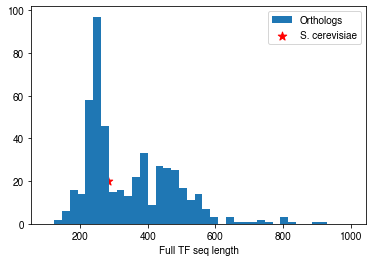

S.cer Gcn4 is 281 AA
The median TF length is 297 AA
The minimum TF length is 134 AA
The maximum TF length is 2943 AA
26 TFs are longer than 600 AA


In [5]:
bins = np.linspace(100,1000,40)
# bins[-1] =4000
histpair = plt.hist(FullOrthoDF.Length,bins,label='Orthologs')
# bins = histpair[1]
# heights = np.array(histpair[0])
# heights = np.append(heights,)
# plt.bar(1000,sum(FullOrthoDF.Length>1000),label='Long',facecolor='green')
plt.scatter([281],[20],c='r',s=80,marker='*',label ='S. cerevisiae')
plt.xlabel('Full TF seq length'),plt.legend()
plt.show()
print('S.cer Gcn4 is 281 AA')
print('The median TF length is %i AA'%np.median(FullOrthoDF.Length))
print('The minimum TF length is %i AA'%min(FullOrthoDF.Length))
print('The maximum TF length is %i AA'%max(FullOrthoDF.Length))
print('%i TFs are longer than 600 AA'%sum(FullOrthoDF.Length>600))

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/589279901.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['WxxLF_loc'] = ReturnMotifLocations(FullOrthoDF,'W.[SPA]LF',column='Seq')
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/589279901.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['Spacer'] = FullOrthoDF.Length - FullOrthoDF.WxxLF_loc


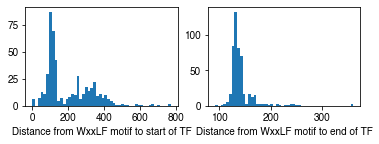

In [6]:
# location of WxxLF motif in each full length TF
tempcol = []
def ReturnMotifLocations(currentDF, motif,column='Seq'):
    tempcol = []
    for seq in currentDF[column]:
        hits = re.search(motif,seq)
        if hits:
            tempcol.append(hits.start())
        else:
            tempcol.append(-1)
    return tempcol
FullOrthoDF['WxxLF_loc'] = ReturnMotifLocations(FullOrthoDF,'W.[SPA]LF',column='Seq')

# location of DBD in each full length TF

#hist of distances between WxxLF and DBD
#Approx with end of protein
FullOrthoDF['Spacer'] = FullOrthoDF.Length - FullOrthoDF.WxxLF_loc

#leave out the few very long TFs
indx = FullOrthoDF.Length < 1000
tempDF = FullOrthoDF[indx]
plt.subplot(2,2,1)
plt.hist(tempDF.WxxLF_loc,50)
plt.xlabel('Distance from WxxLF motif to start of TF')
plt.subplot(2,2,2)
plt.hist(tempDF.Spacer,50)
plt.xlabel('Distance from WxxLF motif to end of TF')
plt.show()



In [7]:
exportfilename = 'ExportedSeqLists/FullLengthUniqueOrthologs.fasta'
tempDict = dict(zip(FullOrthoDF.SpeciesName,FullOrthoDF.Seq))
protfasta.write_fasta(tempDict,exportfilename)

In [8]:
# How many TFs have WxxLF motif? How many have 2? 
motiflist = ['W..LF','[WFYL]..[WFYL][WFYL]','M..Y..L','MF.Y..L','[FWYL].[FWYL]..[FWYL]','[WFL]..[WFL][WFL]','[DE][WFY]','[DE][WFY]*[DE][WFY]','FF','F.F','F..F']

FullOrthoDF = YAF.CountMotifs(FullOrthoDF,motiflist,column='Seq',plothist=False)

for motif in motiflist:
    print(motif)
    print('%i TFs have at least one instance of this motif'%sum(FullOrthoDF[motif]>0))
    print('%i TFs have at least two instances of this motif'%sum(FullOrthoDF[motif]>1))
    print('%i TFs have at least three instances of this motif\n'%sum(FullOrthoDF[motif]>2))
indx =FullOrthoDF['[WFYL]..[WFYL][WFYL]']>1
tempDF =FullOrthoDF[indx]
tempDF

W..LF
502 TFs have at least one instance of this motif
0 TFs have at least two instances of this motif
0 TFs have at least three instances of this motif

[WFYL]..[WFYL][WFYL]
502 TFs have at least one instance of this motif
176 TFs have at least two instances of this motif
65 TFs have at least three instances of this motif

M..Y..L
7 TFs have at least one instance of this motif
0 TFs have at least two instances of this motif
0 TFs have at least three instances of this motif

MF.Y..L
5 TFs have at least one instance of this motif
0 TFs have at least two instances of this motif
0 TFs have at least three instances of this motif

[FWYL].[FWYL]..[FWYL]
188 TFs have at least one instance of this motif
74 TFs have at least two instances of this motif
25 TFs have at least three instances of this motif

[WFL]..[WFL][WFL]
502 TFs have at least one instance of this motif
160 TFs have at least two instances of this motif
47 TFs have at least three instances of this motif

[DE][WFY]
479 TFs have at

/Users/maxstaller/Library/CloudStorage/Box-Box/ComputationalWork/Yeast_UCB/Analysis/YeastAnalysisfunctions.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentDF[motif]=tempcol
/Users/maxstaller/Library/CloudStorage/Box-Box/ComputationalWork/Yeast_UCB/Analysis/YeastAnalysisfunctions.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentDF[motif]=tempcol
/Users/maxstaller/Library/CloudStorage/Box-Box/ComputationalWork/Yeast_UCB/Analysis/YeastAnalysisfunctions.py:17: SettingWithCopyWarning: 
A v

,SpeciesName,Seq,Length,WxxLF_loc,Spacer,W..LF,[WFYL]..[WFYL][WFYL],M..Y..L,MF.Y..L,[FWYL].[FWYL]..[FWYL],[WFL]..[WFL][WFL],[DE][WFY],[DE][WFY]*[DE][WFY],FF,F.F,F..F
0,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQA...,2928,1006,1922,1,12,0,0,10,9,25,7,4,0,6
5,Sordariomycetes_jgi|Acral2|2047914|estExt_Gene...,MADTCGGSTPLKNFSQYGSQDRSLQQDRVVHGFHGSAAAGPSTFRS...,2943,1021,1922,1,12,0,0,10,9,25,7,4,0,6
15,Leotiomycetes_jgi|Amore1|20362|gm1.6031_g,MAWPPGLCSLESGRWFRLALDPGGGTALGSLCPLVCPAQWYAYVIG...,520,390,130,1,2,0,0,0,2,5,1,0,0,3
17,Leotiomycetes_jgi|Amore1|51693|fgenesh1_pm.8_#...,MAWPPGLCSLESGRWFRLALDPGGGTALGSLCPLVCPAQWYAYVIG...,499,369,130,1,2,0,0,0,2,4,1,0,0,3
18,Leotiomycetes_jgi|Amore1|29065|fgenesh1_pg.8_#...,MAWPPGLCSLESGRWFRLALDPGGGTALGSLCPLVCPAQWSTPGWG...,534,404,130,1,2,0,0,0,2,5,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,Cten_EGV62856.1_CandidaTenuisATCC10573,MSKMFSPVILNDTFIGSNPVEGSNEKEMNKVPKLATDESAPGLSAP...,251,87,164,1,2,0,0,1,2,3,1,0,1,0
1197,Cdub_XP_002418875.1_CandidaDubliniensisCD36,MSATTPIIYEDSLFESQDLFASPKVKQFHQKVVADTTTTTNTTTTT...,321,117,204,1,2,0,0,0,2,1,1,0,0,0
1198,Cmal_EMG49335.1_CandidaMaltosaXu316,MSATTPAVYEDSLFESQDLFAAPAPRQTEASLAEKDVELELISALP...,314,103,211,1,3,0,0,0,3,2,1,0,0,0
1199,Cort_emb_CCG25633.1_CandidaOrthopsilosis,MSAATTTTPVDFEDSLFESHEMINEKMIEPRKNVTPATAAATATAT...,353,108,245,1,3,0,0,0,3,5,1,0,0,0


In [9]:
# look at Orthologs with more than 1 phixxphiphi motif
motif = '[WFYL]..[WFYL][WFYL]'
indx = FullOrthoDF[motif]>1
tempFullDF = FullOrthoDF[indx]
specieslist =set(tempFullDF.SpeciesName)
# specieslist

In [10]:
FullOrthoDF.columns

Index(['SpeciesName', 'Seq', 'Length', 'WxxLF_loc', 'Spacer', 'W..LF',
       '[WFYL]..[WFYL][WFYL]', 'M..Y..L', 'MF.Y..L', '[FWYL].[FWYL]..[FWYL]',
       '[WFL]..[WFL][WFL]', '[DE][WFY]', '[DE][WFY]*[DE][WFY]', 'FF', 'F.F',
       'F..F'],
      dtype='object')

In [11]:
# How many of the TFs have an AD
print('There are %i TFs '% len(Orthologs_DF.SpeciesNames.unique()))
thresholds = [80,85,90,91,92,93,95,97,99, 100]
for quantile in thresholds:
    if quantile == 100:
        thresh = 100000
    else:
        thresh = masterDF[Activity].quantile(quantile/100.0)
    counter = 0
    for j, species in enumerate(Orthologs_DF.SpeciesNames.unique()):
        indx = (Orthologs_DF.SpeciesNames==species)
        tempDF = Orthologs_DF[indx]
        indx = tempDF.Activity>thresh
        if sum(indx)>0:
            counter+=1
    print('At a threshold of %i (%ith percentile), %i TFs have an AD, %.1f percent'%(thresh,quantile,counter,100.0*counter/(j+1)))


There are 502 TFs 
At a threshold of 94031 (80th percentile), 501 TFs have an AD, 99.8 percent
At a threshold of 120506 (85th percentile), 501 TFs have an AD, 99.8 percent
At a threshold of 164610 (90th percentile), 496 TFs have an AD, 98.8 percent
At a threshold of 175525 (91th percentile), 496 TFs have an AD, 98.8 percent
At a threshold of 187791 (92th percentile), 496 TFs have an AD, 98.8 percent
At a threshold of 201656 (93th percentile), 495 TFs have an AD, 98.6 percent
At a threshold of 226894 (95th percentile), 490 TFs have an AD, 97.6 percent
At a threshold of 248358 (97th percentile), 428 TFs have an AD, 85.3 percent
At a threshold of 261029 (99th percentile), 317 TFs have an AD, 63.1 percent
At a threshold of 100000 (100th percentile), 501 TFs have an AD, 99.8 percent


No ADs
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 24.5
 25.5]


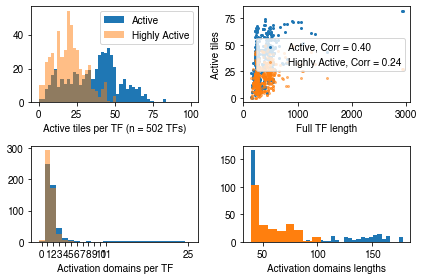

248 TFs have one active AD
293 TFs have one strong AD
5 TFs have no strong ADs (or 5 counting another way)
249 TFs have only one active AD and it overlaps the WxxLF motif
295 TFs have only one strong AD and it overlaps the WxxLF motif


In [12]:
# for each TF how many active tiles?
## SLOW
HighActivityThresh = 150000

tempDict ={}
NumActive,NumHighActive, lengths = [],[],[]
NumADs,NumHighADs =[],[]
NumTFswOneAD,NumTFswOneAD_high,NumTFswZeroAD_high =0,0,0
TileLength = 40
genenames, starts,ends, seqs,regionlengths,regionlengthsHigh,RegionType = [],[],[],[],[],[],[]
SingleADoverlapsWxxLF,SingleADoverlapsWxxLF_Strong =0,0
LengthDict = dict(zip(FullOrthoDF.SpeciesName,FullOrthoDF.Length))
for ii, name in enumerate( set(Orthologs_DF.SpeciesNames)):
    indx = Orthologs_DF.SpeciesNames==name
    
    tempDF = Orthologs_DF[indx] # DF for all tiles for each ortholog
    NumActive.append(sum(tempDF.Activity>ActivityThresh))
    NumHighActive.append(sum(tempDF.Activity>HighActivityThresh))
    lengths.append(LengthDict[name])
    #combine overlapping tiles to estimate number of ADs. 
    tempDF2 = tempDF[tempDF.Activity>ActivityThresh]#active tiles
    tempDF2 = tempDF2.sort_values(by='NativeLocation',ascending=True)
    tempDF2 = tempDF2.reset_index()
    #check if there are no ADs
    if len(tempDF2)==0:
        NumADs.append(0)
        print('No ADs')
    else:
        tempNumADs =1
        previousstart = (tempDF2.NativeLocation[0]-19)
        previousend   = (tempDF2.NativeLocation[0]+20)
        for i, entry in tempDF2.iterrows():
            if (entry.NativeLocation-19) < (previousend):
                previousend = entry.NativeLocation+20
            else:
                starts.append(previousstart)
                ends.append(previousend)
                tempNumADs +=1
                regionlengths.append(previousend-previousstart)
                previousstart = entry.NativeLocation-19
                previousend   = entry.NativeLocation+20
        NumADs.append(tempNumADs)
    #check if single AD overlaps WxxLF
    if tempNumADs ==1:
        correction = entry.NativeLocation - entry.NormLocation
        if ((previousstart -correction <0 ) & (previousend-correction >0)):
            SingleADoverlapsWxxLF +=1
        else:
            print(name)
            print(tempDF2)

        
        
        
    tempDF2 = tempDF[tempDF.Activity>HighActivityThresh]#active tiles
    tempDF2 = tempDF2.sort_values(by='NativeLocation',ascending=True)
    tempDF2 = tempDF2.reset_index()
    starts,ends =[],[]
    #check if there is only one AD
    if len(tempDF2)==0:
        NumTFswZeroAD_high+=1
        NumHighADs.append(0)
    else:
        tempNumADs =1
        previousstart = (tempDF2.NativeLocation[0]-19)
        previousend   = (tempDF2.NativeLocation[0]+20)
        for i, entry in tempDF2.iterrows():
            if (entry.NativeLocation-19) < (previousend):
                previousend = entry.NativeLocation+20
            else:
                starts.append(previousstart)
                ends.append(previousend)
                tempNumADs +=1
                regionlengthsHigh.append(previousend-previousstart)
                previousstart = entry.NativeLocation-19
                previousend   = entry.NativeLocation+20
        NumHighADs.append(tempNumADs)
    #check if single AD overlaps WxxLF
    if tempNumADs ==1:
        correction = entry.NativeLocation - entry.NormLocation
        if ((previousstart -correction <0 ) & (previousend-correction >0)):
            SingleADoverlapsWxxLF_Strong +=1


# nubmer of active tiles   
plt.subplot(2,2,1)
bins = np.linspace(0,100)
plt.hist(NumActive,bins,label='Active')
plt.hist(NumHighActive,bins,alpha = .5,label='Highly Active')
plt.xlabel('Active tiles per TF (n = %i TFs)'%len(set(Orthologs_DF.SpeciesNames)))
plt.legend()
# TF length vs number acitve tiles
plt.subplot(2,2,2)
corr = scipy.stats.pearsonr(lengths,NumActive)
plt.scatter(lengths,NumActive,s=4,label = 'Active, Corr = %.2f'%corr[0])
#corr length
corr2 = scipy.stats.pearsonr(lengths,NumHighActive)
plt.scatter(lengths,NumHighActive,s=4,alpha=.5,label = 'Highly Active, Corr = %.2f'%corr2[0])
plt.xlabel('Full TF length'),plt.ylabel('Active tiles')
# plt.text('Corr = %.2f'%corr[0])
plt.legend(loc='center right')

#number fo agragated ADs per TF
plt.subplot(2,2,3)
bins = np.array([-1,0,1,2,3,4,5,6,7,8,9,10,11,24,25])+.5
print(bins)
plt.hist(NumADs,bins)
plt.hist(NumHighADs,bins,alpha=.5)
# plt.yscale('log')
plt.xlabel('Activation domains per TF')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,25])

plt.subplot(2,2,4)
plt.hist(regionlengths,36)
plt.hist(regionlengthsHigh,8,alpha=1)
plt.tight_layout()
plt.xlabel('Activation domains lengths')

plt.savefig('Figures/PaperFigs/ADcounts.pdf')
plt.show()

print('%i TFs have one active AD'%sum(x==1 for x in NumADs))
print('%i TFs have one strong AD'%sum(x==1 for x in NumHighADs))
print('%i TFs have no strong ADs (or %i counting another way)'%(sum(x==0 for x in NumHighADs),NumTFswZeroAD_high))
print('%i TFs have only one active AD and it overlaps the WxxLF motif'%SingleADoverlapsWxxLF)
print('%i TFs have only one strong AD and it overlaps the WxxLF motif'%SingleADoverlapsWxxLF_Strong)

#### For each species, how many tiles have WxxLF and no activity? high activity? medium activity? 


Sordariomycetes_jgi|Hypfra2|223471|CE223470_113748
12 active tiles
0 highly active tiles
Sordariomycetes_jgi|Hypfra2|530715|MIX4042_126314_88
18 active tiles
5 highly active tiles
Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g
3 active tiles
0 highly active tiles
Sordariomycetes_jgi|Hypfra2|485502|fgenesh1_kg.4_#_1379_#_TRINITY_DN1166_c0_g1_i1
15 active tiles
4 highly active tiles
Sordariomycetes_jgi|Hypfra2|485503|fgenesh1_kg.4_#_1380_#_TRINITY_DN1166_c0_g2_i1
11 active tiles
0 highly active tiles
Cgla_CAGL0L02475g
8 active tiles
6 highly active tiles
Leotiomycetes_jgi|Oidma1|18868|fgenesh1_kg.6_#_311_#_isotig02349
1 active tiles
0 highly active tiles
Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1
0 active tiles
0 highly active tiles
8 TFs have no WxxLF tiles that are highly active
45 TFs have no WxxLF tiles that are active
Counter 5 has 5 0 entries


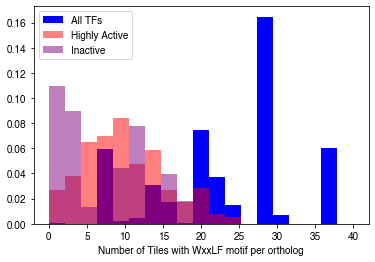

In [13]:
# count motifs on tiles
def CountMotifs(currentDF, motiflist,column='ADseq',printstats =True, plothist=True):
    for motif in motiflist:
        tempcol = []
        for seq in currentDF[column]:
            hits = re.search(motif,seq)
            if hits:
                matches = re.findall(motif,seq)
                tempcol.append(len(matches))
            else:
                tempcol.append(0)
        currentDF[motif]=tempcol
        if  printstats :
#             plt.hist(currentDF[Activity],150) #Blue hist includes not detected ADs
            indx = (currentDF[motif]>0)&(currentDF.Recovered)
            tempDF  =  currentDF[indx]
            notindx = (currentDF[motif]==0)&(currentDF.Recovered)
            notDF = currentDF[notindx]
            # stats does not use non detected ADs
            test = stats.ttest_ind(tempDF[Activity],notDF[Activity], equal_var=False)
            print(motif)
            print('%.1f (n=%i) with vs %.1f without (%i)\n'%(np.mean(tempDF[Activity]),sum(indx),np.mean(notDF[Activity]),sum((currentDF[motif]==0)&(currentDF.Recovered))))
            print(test)
        if plothist:
            #Blue hist does not use non detected ADs
            plt.hist(notDF[Activity],150,density=True) 
            # orange hist does not use non detected ADs
            plt.hist(tempDF[Activity],150,alpha=.5,density=True)
            plt.show()
    return currentDF
motiflist = ['W..LF']
Orthologs_DF = CountMotifs(Orthologs_DF,motiflist,column='Seq',printstats =False,plothist=False)

#for each ortholog
Counter1,Counter2,Counter3,Counter4,Counter5 = [],[],[],[],[]
motif = 'W..LF'
for i, species in enumerate(set(Orthologs_DF.SpeciesNames)):
    indx = Orthologs_DF.SpeciesNames==species
    tempDF = Orthologs_DF[indx]
    tempDF = tempDF.reindex()
    #count total WxxLF tiles
    count1 = sum((tempDF[motif]==1))
    Counter1.append(count1)
    #count for active tiles with WxxLF
    count2 = sum((tempDF[motif]==1)&(tempDF['Activity']>ActivityThresh))
    Counter2.append(count2)
    # look for highly tiles with WxxLF
    count3 = sum((tempDF[motif]==1)&(tempDF['Activity']>HighActivityThresh))
    Counter3.append(count3)
    # look for inactive tiles with WxxLF
    count4 = sum((tempDF[motif]==1)&(tempDF['Activity']<ActivityThresh))
    Counter4.append(count4)
    if count3 ==0:
        print(species)
        tempCount = sum(tempDF['Activity']>ActivityThresh)
        print('%i active tiles'%tempCount)
        tempCount2 = sum(tempDF['Activity']>HighActivityThresh)
        print('%i highly active tiles'%tempCount2)
        Counter5.append(tempCount2)
# how many TFS have NO WxxLF tiles with activity
bins = np.linspace(0,40,20)
plt.hist(Counter1,bins,color='blue',density=True,label='All TFs')
                 
plt.hist(Counter3,bins,color='red',alpha=.5,density=True,label='Highly Active')
plt.hist(Counter4,bins,color='purple',alpha=.5,density=True,label='Inactive')
plt.xlabel('Number of Tiles with WxxLF motif per ortholog'),plt.legend()
plt.savefig('Figures/PaperFigs/CountNumberTilesWithWxxLFmotif.pdf')
array = np.array(Counter3)
print('%i TFs have no WxxLF tiles that are highly active'%sum(array==0))
array = np.array(Counter4)
print('%i TFs have no WxxLF tiles that are active'%sum(array==0))

array = np.array(Counter5)
print('Counter 5 has %i 0 entries'%sum(array==0))


In [14]:
# indx = Orthologs_DF.SpeciesNames =='Saccharomycotina_jgi|Canca1|23981|e_gw1.2.2068.1'
# tempDF = Orthologs_DF[indx]
# tempDF = tempDF.sort_values(by='NativeLocation')
# tempDF#['NativeLocation',  'NormLocation', Activity]
# tempDF2 = tempDF[tempDF['Activity']>ActivityThresh]#
# tempDF2 = tempDF2.reset_index()
# tempDF2

# if len(tempDF2)==0:
#     NumADs.append(0)
#     print('No ADs')
# else:
#     tempNumADs =1
#     previousstart = (tempDF2.NativeLocation[0]-19)
#     previousend   = (tempDF2.NativeLocation[0]+20)
#     print('%i  %i'%(previousstart,previousend))
#     for i, entry in tempDF2.iterrows():
#         currentstart,currentend = entry.NativeLocation-19,entry.NativeLocation+20
#         print()
#         print('%i   %i  %i current tile'%(i, currentstart,currentend))
#         print('%i  %i  %i previous start, previous end'%(i,previousstart,previousend))

#         if ((currentstart) < (previousend)):#&((entry.NativeLocation+20)  (previousstart+TileLength)):
#             # if tile start is before previous end.     AND current 
#             previousend = entry.NativeLocation+20
#             print('%i  %i  %i if statement'%(i,previousstart,previousend))
#             print()
#         else:
#             print()
#             starts.append(previousstart)
#             ends.append(previousend)
#             tempNumADs +=1
#             regionlengths.append(previousend-previousstart)
#             previousstart = entry.NativeLocation-19
#             previousend   = entry.NativeLocation+20
#             print('%i  %i  %i reset inside else'%(i,previousstart,previousend))
#     NumADs.append(tempNumADs)
# #check if single AD overlaps WxxLF
# if tempNumADs ==1:
#     correction = entry.NativeLocation - entry.NormLocation
#     if ((previousstart -correction <0 ) & (previousend-correction >0)):
#         SingleADoverlapsWxxLF +=1
#     else:
#         print(name)
#         print(tempDF2)
# tempNumADs

(array([  1., 248., 183.,  44.,   0.,  13.,   6.,   2.,   0.,   0.,   2.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.]),
 array([ 0.  ,  0.76,  1.52,  2.28,  3.04,  3.8 ,  4.56,  5.32,  6.08,
         6.84,  7.6 ,  8.36,  9.12,  9.88, 10.64, 11.4 , 12.16, 12.92,
        13.68, 14.44, 15.2 , 15.96, 16.72, 17.48, 18.24, 19.  ]),
 <BarContainer object of 25 artists>)

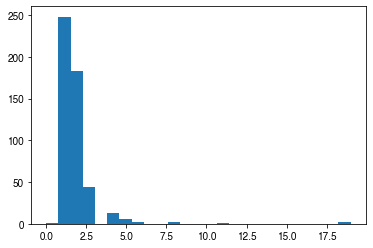

In [15]:
a =plt.hist(NumADs,25)
sum(a[0])
a

## Combine active tiles to count #ADs per TF

In [16]:
tempDF2

,index,Unnamed: 0,SpeciesNames,NativeLocation,NormLocation,Seq,Activity,Stdev_BioReps
0,58040,58040,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,33,-63,FSSPAMAASYDLTSSVSSSSASNLGTVSPNDLLLQDSFMS,161831.595832,25170.899664
1,58012,58012,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,81,-15,SLTSPSDFNDSPYGDSYDVSPNFGGNDFEAGAHDTWFPLF,207675.950879,824.299359
2,57974,57974,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,82,-14,LTSPSDFNDSPYGDSYDVSPNFGGNDFEAGAHDTWFPLFA,170561.913436,22266.446258
3,58088,58088,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,85,-11,PSDFNDSPYGDSYDVSPNFGGNDFEAGAHDTWFPLFAQDT,192183.397858,45116.653461
4,58013,58013,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,86,-10,SDFNDSPYGDSYDVSPNFGGNDFEAGAHDTWFPLFAQDTS,202877.775137,1711.840537
5,57975,57975,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,87,-9,DFNDSPYGDSYDVSPNFGGNDFEAGAHDTWFPLFAQDTSV,237125.332237,NaN
6,58090,58090,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,95,-1,DSYDVSPNFGGNDFEAGAHDTWFPLFAQDTSVAAGPVAGG,172108.278292,41872.143718
7,58091,58091,Sordariomycetes_jgi|OphPMI507_1|294364|gw1.10....,100,4,SPNFGGNDFEAGAHDTWFPLFAQDTSVAAGPVAGGVSASP,184424.287935,77239.502816


# Compare Activity to ADpred scores

In [17]:
ADpredDF = pd.read_csv('../Data/ADpred_GCN4_yeast_orthologs/add_adpred__GCN4_orthologs_under1000.csv')
ADpredDF_dict = dict(zip(ADpredDF.GeneName,ADpredDF.position_wise_prob_adpred))
tempSeries = FullOrthoDF.SpeciesName
FullOrthoDF['ADpred'] = tempSeries.map(ADpredDF_dict)
# FullOrthoDF['ADpred']
FullOrthoDF.to_csv('../Data/Processed/FullLengthOrthologs.csv')
#helper function
def convertADpredString2Array(ADpredString):
    a = ADpredString.replace('\n','')
    a = a.replace('[','')
    a = a.replace(']','').split(',')
    b = np.array([float(x) for x in a])
    return b

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/1701267737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['ADpred'] = tempSeries.map(ADpredDF_dict)


/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/4151073904.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['WxxLF_loc'] = ReturnMotifLocations(FullOrthoDF,'W.[SPA]LF',column='Seq')
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/4151073904.py:28: RuntimeWarning: Mean of empty slice
  tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/4151073904.py:28: RuntimeWarning: Mean of empty slice
  tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/4151073904.py:28: RuntimeWarning: Mean of empty slice
  tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
/var/folders/rc/pd8xzhm53gv2fky47bfzkc

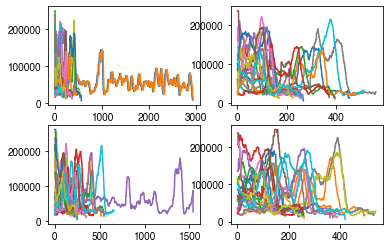

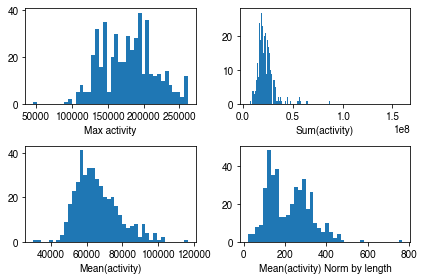

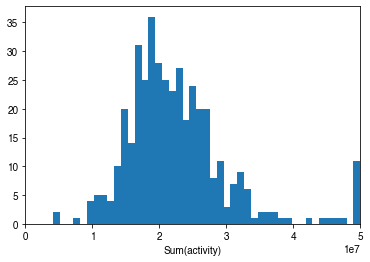

/var/folders/rc/pd8xzhm53gv2fky47bfzkc440000gn/T/ipykernel_1811/4151073904.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FullOrthoDF['SmoothedActivites'] = tempSeries.map(SmoothedActivites)


In [18]:
def ReturnMotifLocations(currentDF, motif,column='Seq'):
    tempcol = []
    for seq in currentDF[column]:
        hits = re.search(motif,seq)
        if hits:
            tempcol.append(hits.start())
        else:
            tempcol.append(-1)
    return tempcol
FullOrthoDF['WxxLF_loc'] = ReturnMotifLocations(FullOrthoDF,'W.[SPA]LF',column='Seq')

SmoothedActivites = defaultdict()
maxes=[]
sums=[]
avgs,normbylengavg =[],[]
for j, species in enumerate(Orthologs_DF.SpeciesNames.unique()):
    indx = (Orthologs_DF.SpeciesNames==species)
    tempDF = Orthologs_DF[indx]
    tempMatrix = np.zeros((len(tempDF)+1,max(tempDF.NativeLocation)+20))
#     print(tempMatrix.shape)
    k =0
    for i, tile in tempDF.iterrows():
        tempMatrix[k,tile.NativeLocation-20:tile.NativeLocation+20]= tile.Activity
        k+=1
        
    tempMatrix = tempMatrix.astype('float')
    tempMatrix[tempMatrix==0]=np.nan
    tempSmoothTrace = np.nanmean(tempMatrix,axis=0)
    SmoothedActivites[species] = tempSmoothTrace
    maxes.append(max(tempSmoothTrace))
    sums.append(np.sum(tempSmoothTrace))
    avgs.append(np.mean(tempSmoothTrace))
    normbylengavg.append(np.mean(tempSmoothTrace)/len(tempSmoothTrace))
    if j <80:
        plt.subplot(2,2,j%4+1)
        plt.plot(tempSmoothTrace)
    
#         print(tempMatrix.shape)
plt.show()

plt.subplot(2,2,1)
plt.hist(maxes,40), plt.xlabel('Max activity')
plt.subplot(2,2,2)
plt.hist(sums,200), plt.xlabel('Sum(activity)')
plt.subplot(2,2,3)
plt.hist(avgs,40) , plt.xlabel('Mean(activity)')
plt.subplot(2,2,4)
plt.hist(normbylengavg,40), plt.xlabel('Mean(activity) Norm by length')
plt.tight_layout()
plt.show()

bins = np.linspace(0,5e7,50)
bins[-1] = 1.6e8
plt.hist(sums,bins), plt.xlabel('Sum(activity)')
plt.xlim([0,5e7])
plt.show()

tempSeries = FullOrthoDF.SpeciesName
FullOrthoDF['SmoothedActivites'] = tempSeries.map(SmoothedActivites)


# 20220607 I checked that the average activity at each position is being calculated correctly. Downloaded last one and calculated smoothing by hand  in numbers.

#  Alignment distance with Edit Distance

In [96]:
# alignment distance vs activity difference 

# very slow to run.

def Calc_AlignmentDists(tempDF):
    mindists ={}
    minExpDiffs = {}
    
    Seqlist = tempDF.ADseq.values
    AlignmentDists = np.zeros((len(Seqlist),len(Seqlist)))
    AllAlignementDistsForExport =[]
    AllEditDistsForExport = []
    print (AlignmentDists.shape)
    ActDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
    for i, seq1 in enumerate(Seqlist):
        tempdists = []
        expdists = []
        for j, seq2 in enumerate(Seqlist):
            if i>j:
                tempDist =editdistance.eval(seq1,seq2)
                tempdists.append(tempDist)
                tempExpdist = np.abs(ActDict[seq1]-ActDict[seq2])
                expdists.append(tempExpdist)
                AllAlignementDistsForExport.append(tempDist)
                AllEditDistsForExport.append(tempExpdist)
                AlignmentDists[i,j]=tempDist
        if i>0:
            indx = min(tempdists)==tempdists
            mindists[seq1] =(min(tempdists))
            minExpDiffs[seq1] = (expdists[indx])
    return AlignmentDists,tempdists,AllEditDistsForExport
tempDF = masterDF[masterDF.Recovered]
AlignmentDists,AllEditDists,AllExpDists = Calc_AlignmentDists(tempDF)
temp = pd.DataFrame(AlignmentDists)
# temp.to_csv('../Data/Processed/AlignmentDistances.csv')
print('Found %i EditDistances'%len(AllEditDists))
print('Found %i Exp Distances'%len(AllEditDists))
Seqlist = tempDF.ADseq.values
tempSeries = masterDF.ADseq
# masterDF['MinEditDist']= tempSeries.map(mindists)
# masterDF['MinExpDiff']= tempSeries.map(minExpDiffs)


(18947, 18947)
Found 18946 EditDistances
Found 18946 Exp Distances


Text(336.9714285714286, 0.5, 'Expression difference')

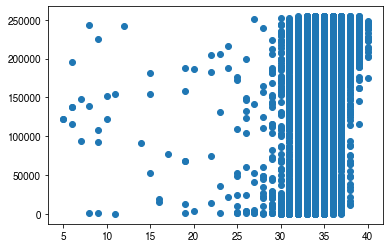

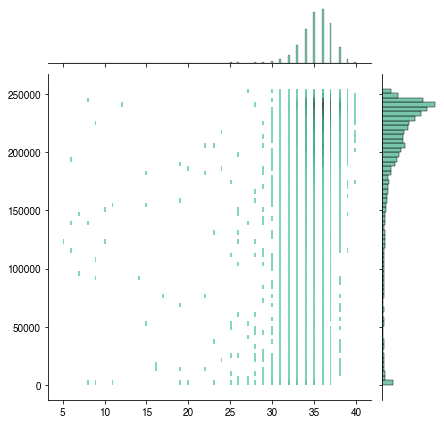

In [92]:
plt.scatter(AllEditDists,AllExpDists)
# newDF = pd.DataFrame({'EditDistance':AllEditDists,'ExpDistance':AllExpDists})
sns.jointplot(x=AllEditDists, y=AllExpDists, kind="hist", color="#4CB391")
plt.xlabel('Edit Distance')
plt.ylabel('Expression difference')

In [95]:
sum(np.array(AllEditDists)<20)
len(AlignmentDists)

18947

In [20]:
# temp = pd.read_csv('../Data/Processed/AlignmentDistances.csv')
# AlignmentDists = (temp.values)

In [55]:
temp = pd.DataFrame(AlignmentDists)


In [75]:
def Calc_ExpDists(tempDF):
    mindists ={}
    minExpDiffs = {} 
    Seqlist = tempDF.ADseq.values
    ExpDists = np.zeros((len(Seqlist),len(Seqlist)))
    print (AlignmentDists.shape)
    ActDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
    for i, seq1 in enumerate(Seqlist):
        expdists = []
        for j, seq2 in enumerate(Seqlist):
            if i>j:
                tempexpdists = (np.abs(ActDict[seq1]-ActDict[seq2]))
                ExpDists[i,j]=tempexpdists
       
    return ExpDists
tempDF = masterDF[masterDF.Recovered]
ExpDistsDF = Calc_AlignmentDists(tempDF)


(18947, 18947)


KeyboardInterrupt: 

In [74]:
plt.scatter(AlignmentDists.ravel, ExpDistsDF.ravel)

(18947, 18947)

In [56]:


indx = masterDF.Recovered & (masterDF[Activity]>ActivityThresh)
indx = masterDF.Recovered
tempDF = masterDF[indx]
AlignmentDists_Active = Calc_AlignmentDists(tempDF)


        


(18947, 18947)


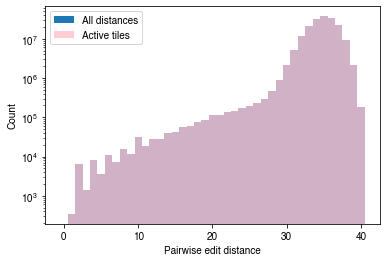

In [57]:
temp2 = np.ravel(AlignmentDists)
temp3 = temp2[temp2>0]
plt.hist(temp3,np.linspace(-.5,40.5,42),label='All distances')
plt.yscale('log')
temp2 = np.ravel(AlignmentDists_Active)
temp3 = temp2[temp2>0]
plt.hist(temp3,np.linspace(-.5,40.5,42),label='Active tiles',alpha=.8,color='pink')
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Pairwise edit distance')
plt.legend()
plt.savefig('Figures/PaperFigs/Supp/EditDistances_HistSummary.pdf')
plt.show()

In [58]:
for dist in [1,2,3]:
    indx = AlignmentDists==dist
    print('There are %i pairs with an EditDistance of %i'%(sum(sum(indx)),dist))

There are 345 pairs with an EditDistance of 1
There are 6601 pairs with an EditDistance of 2
There are 1367 pairs with an EditDistance of 3


In [59]:
AlignmentDists.shape

(18947, 18947)

GTVSPSDLFVDASAPPSASFTDLSTPSFDSPGYFSQDTSP	 121654.00
         M                              	 21568.55	
GTVSPSDLFMDASAPPSASFTDLSTPSFDSPGYFSQDTSP	 100085.45

DASAPPSASFTDLSTPSFDSPGYFSQDTSPMFGADLDLAP	 130071.62
                                 T      	 22870.33	
DASAPPSASFTDLSTPSFDSPGYFSQDTSPMFGTDLDLAP	 107201.29

PSASFTDLSTPSFDSPGYFSQDTSPMFGADLDLAPGHEEW	 144928.78
                            T           	 26527.85	
PSASFTDLSTPSFDSPGYFSQDTSPMFGTDLDLAPGHEEW	 171456.63

TDLSTPSFDSPGYFSQDTSPMFGADLDLAPGHEEWAPLFP	 232746.38
                       T                	 48624.15	
TDLSTPSFDSPGYFSQDTSPMFGTDLDLAPGHEEWAPLFP	 184122.23

PSFDSPGYFSQDTSPMFGADLDLAPGHEEWAPLFPSNDGM	 221871.74
                  T                     	 22380.38	
PSFDSPGYFSQDTSPMFGTDLDLAPGHEEWAPLFPSNDGM	 244252.12

PGYFSQDTSPMFGADLDLAPGHEEWAPLFPSNDGMSMPFD	 246009.22
             T                          	 103762.09	
PGYFSQDTSPMFGTDLDLAPGHEEWAPLFPSNDGMSMPFD	 142247.14

VSARRSKPLPPIKYDESDPVAAKRARNTEAARKSRARKLE	 62964.86
 N    

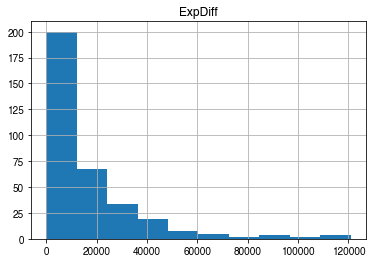

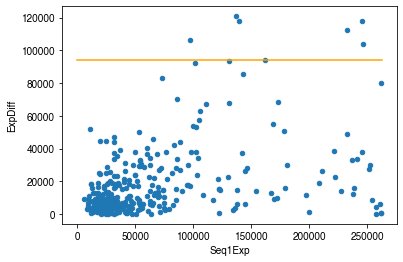

In [60]:
def MakeEditDistDF(dist):
    seq1list,seq2list,expDifflist =[],[],[]
    counter =0
    for i, seq1 in enumerate(Seqlist):
        for j, seq2 in enumerate(Seqlist):
            if AlignmentDists[i,j] == dist:
                comparisonstring = []
                seq1list.append(seq1)
                seq2list.append(seq2)
                expDiff = np.abs(MapADseq2Activity[seq1]-MapADseq2Activity[seq2])
                expDifflist.append(expDiff)
                for k, car in enumerate(seq1):
                    if car == seq2[k]:
                        comparisonstring.append(' ')
                    else:
                        comparisonstring.append(seq2[k])
                if counter <20:
                    print('%s\t %.2f'%(seq1,MapADseq2Activity[seq1]))
                    print('%s\t %.2f\t'%(''.join(comparisonstring),expDiff))
                    print('%s\t %.2f\n'%(seq2,MapADseq2Activity[seq2]))
                    counter +=1
#     return seq1list,seq2list,expDifflist
    DistDF = pd.DataFrame({'Seq1':seq1list,'Seq2':seq2list,'ExpDiff':expDifflist})
    tempseries = DistDF['Seq1']
    DistDF['Seq1Exp']= tempseries.map(MapADseq2Activity)
    tempseries = DistDF['Seq2']
    DistDF['Seq2Exp']= tempseries.map(MapADseq2Activity)
    DistDF.hist('ExpDiff')
    
    ExtraCols = ['Activity_BioRepA_BYS4','Activity_BioRepB_BYS4']
    for seq in ['Seq1','Seq2']:
        for col in ExtraCols:
            print('%s %s'%(seq, col))
            TempMapADseq2Activity = dict(zip(masterDF.ADseq,masterDF[col]))
            tempseries = DistDF[seq]
            DistDF[seq+'_'+col]= tempseries.map(TempMapADseq2Activity)
    
    plt.show()
    DistDF.plot.scatter(x='Seq1Exp', y = 'ExpDiff')
    plt.plot([0,maxActivity],[ActivityThresh,ActivityThresh],c='orange')
    plt.show()
    
    return DistDF
Seqlist = tempDF.ADseq.values
CurrentEditDist =1
Dist1DF =  MakeEditDistDF(CurrentEditDist)
sortedDF = Dist1DF.sort_values(by='ExpDiff',ascending=False)
# sortedDF

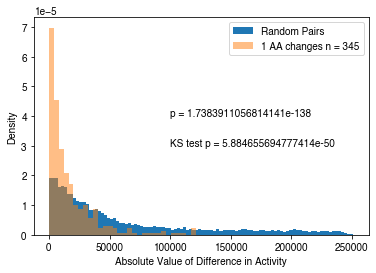

In [61]:
##generate a null distribution for differences in activity between two tiles
N = 10000
holdActDeltas = []
tempDF = masterDF[masterDF.Recovered]
for i in range(0,N):
    sampledDF = tempDF.sample(n=2, random_state=i)
    tempArray = sampledDF[Activity].values
    tempActDelta = np.abs(tempArray[0]-tempArray[1])
    holdActDeltas.append(tempActDelta)
plt.hist(holdActDeltas,100, density=True,label='Random Pairs')
plt.hist(Dist1DF.ExpDiff,30,alpha=.5, density=True,label='1 AA changes n = %i'%len(Dist1DF))
plt.legend()
test = stats.ttest_ind(Dist1DF.ExpDiff.values,holdActDeltas, equal_var=False)
plt.xlabel('Absolute Value of Difference in Activity'), plt.ylabel('Density')
plt.text(100000,4e-5,'p = %r'%test[1])
test = stats.ks_2samp(Dist1DF.ExpDiff.values,holdActDeltas)
plt.text(100000,3e-5,'KS test p = %r'%test[1])
plt.savefig('Figures/PaperFigs/Supp/PairwiseActivityChanges_1AA.pdf')

In [62]:
# alterative test 
# sample N pairs 10,000 times and look if the mean difference is less for SNPs.

#repeat with pairs. Maybe leave out the hand designed mutants. 

# Dist1DF.ExpDiff.values
# holdActDeltas

KstestResult(statistic=0.405336231884058, pvalue=5.884655694777414e-50)

# To Do: Add statistical test for difference between the 2 measurments 

i.e. For seq1, get the 1 or 2 replicates and for seq2 get the 1 or 2 replicates. 

In [63]:
# do stats
HoldPvalues =[]
def FindSigDiffSeqPairs(tempDF):
    countDoubleSingles,countNominallySignificant, countNominallySignificantANDactive =0,0,0
    for i, row in tempDF.iterrows():
        S1_A = row.Seq1_Activity_BioRepA_BYS4
        S1_B = row.Seq1_Activity_BioRepB_BYS4 
        S2_A = row.Seq2_Activity_BioRepA_BYS4
        S2_B = row.Seq2_Activity_BioRepB_BYS4
        
        pair1 = np.array([S1_A,S1_B])
        pair1 = pair1[~np.isnan(pair1)]
        pair2 = np.array([S2_A,S2_B])
        pair2 = pair2[~np.isnan(pair2)]
        
        test = stats.ttest_ind(pair1,pair2, equal_var=False)
        HoldPvalues.append(test[1])
        if test[1] < 0.05:
            countNominallySignificant += 1
            if (row.Seq1Exp >ActivityThresh )| (row.Seq2Exp>ActivityThresh):
                print(row)
                countNominallySignificantANDactive+=1
                print(test)
        if (len(pair1)==1)and(len(pair2)):
            countDoubleSingles += 1
    print ('%i pairs are nominally significantly differnet'%countNominallySignificant)
    print ('%i of these contain one active seq'%countNominallySignificantANDactive)
    print ('%i pairs have 2 singleton measurments'%countDoubleSingles)

FindSigDiffSeqPairs(Dist1DF)
HoldPvalues

import statsmodels
# correctedPvalues = statsmodels.stats.multitest.fdrcorrection(HoldPvalues, alpha = 0.5, method='indep',is_sorted=False)
# correctedPvalues

Seq1                          TGVHDTSSPSIGPTISPRELLMNPPTSTATTNLASPQSLF
Seq2                          TGVHDTSSPSIGPTISPRELLMNPPTSTATTNLASPLSLF
ExpDiff                                                   70499.534103
Seq1Exp                                                   85773.068733
Seq2Exp                                                  156272.602835
Seq1_Activity_BioRepA_BYS4                                81329.108942
Seq1_Activity_BioRepB_BYS4                                90217.028523
Seq2_Activity_BioRepA_BYS4                               152466.637744
Seq2_Activity_BioRepB_BYS4                               160078.567927
Name: 242, dtype: object
Ttest_indResult(statistic=-12.049151897950296, pvalue=0.007427037083245341)
5 pairs are nominally significantly differnet
1 of these contain one active seq
152 pairs have 2 singleton measurments


/Users/maxstaller/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maxstaller/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### There are few point mutants that cause large changes in activity.


Current Activity Threshold is: 94031 
Current Change in Activity Threshold is: 0.50 


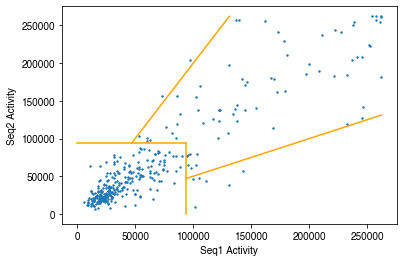

There are 13 point mutations that flip from active to inactive
There are 37 point mutations that cause a 50 percent drop in activity
There are 8 point mutations that cause a 50 percent drop in activity AND one is active
There are 15 point mutations that flip from active to inactive or cause a 50 percent drop in activity
(15, 9)

----------------------------------------



ValueError: not enough values to unpack (expected 4, got 2)

In [104]:
# Focus on point mutatant that cause larger changes in function
# def printADComparisons(Seqlist1,Seqlist2,N=10):
# seq1list,seq2list,expDifflist = [],[],[]
#     for i, seq1 in enumerate(Seqlist1):
#         seq2 =Seqlist2[i]
#         comparisonstring = []
#         seq1list.append(seq1)
#         seq2list.append(seq2)
#         expDiff = np.abs(MapADseq2Activity[seq1]-MapADseq2Activity[seq2])
#         expDifflist.append(expDiff)
        
#         if (seq1[:39]) == (seq2[-39:]):
#             print(seq1[:39])
#             print(seq2[-39:])
#         elif (seq1[1:]) == (seq2[:39]):
#             print(seq1[:39])
#             print(seq2[-39:])
#         else:
#             fromchar, tochar ='',''      
#             for k, car in enumerate(seq1):
#                 if car == seq2[k]:
#                     comparisonstring.append(' ')
#                 else:
#                     fromchar = car
#                     tochar = seq2[k]
#                     comparisonstring.append(tochar)
#             if i <N:
#                 print('%s\t %.2f'%(seq1,MapADseq2Activity[seq1]))
#                 print('%s\t %.2f\t%s'%(''.join(comparisonstring),expDiff,fromchar+'>'+tochar))
#                 print('%s\t %.2f'%(seq2,MapADseq2Activity[seq2]))
#                 print()
def CompareEndResidues(seq1,seq2):
    Hold_WFYLatEndActivityHigher,Hold_WFYLatEndActivityLower =0,0
    # TO DO add counters for number of times a F or L occurs at the end and changes activity
    # find seq with higher activity
    # NOT Working quite right. Misses some and struggles to find many examples. 
    # Counter not working either.
    if MapADseq2Activity[seq1]>MapADseq2Activity[seq2]:
        # find if higher activity seq has WFYL at end
        if (seq1[0] in ['W','F','Y','L','M'])|(seq1[-1] in ['W','F','Y','L','M']):
            Hold_WFYLatEndActivityHigher +=1
            print('Higher activity Seq has a WFYLM at end')
        elif (seq2[0] in ['W','F','Y','L','M'])|(seq2[-1] in ['W','F','Y','L','M']):
            Hold_WFYLatEndActivityLower +=1
            print('LOWER activity Seq has a WFYLM at end')
    if MapADseq2Activity[seq1]<MapADseq2Activity[seq2]:
        # find if higher activity seq has WFYL at end
        if (seq2[0] in ['W','F','Y','L','M'])|(seq2[-1] in ['W','F','Y','L','M']):
            Hold_WFYLatEndActivityHigher +=1
            print('Higher activity Seq has a WFYLM at end')
        elif (seq1[0] in ['W','F','Y','L','M'])|(seq1[-1] in ['W','F','Y','L','M']):
            Hold_WFYLatEndActivityLower +=1
            print('LOWER activity Seq has a WFYLM at end')

def printADComparisons(Seqlist1,Seqlist2,N=10,Counters=[0,0,0,0]):
    seq1list,seq2list,expDifflist = [],[],[]
    Hold_WFYLatEndActivityHigher,Hold_WFYLatEndActivityLower,HoldEDatEndActivityHigher,HoldEDatEndActivityLower = Counters
    for i, seq1 in enumerate(Seqlist1):
        seq2 =Seqlist2[i]
        comparisonstring = []
        seq1list.append(seq1)
        seq2list.append(seq2)
        expDiff = np.abs(MapADseq2Activity[seq1]-MapADseq2Activity[seq2])
        expDifflist.append(expDiff)
        
        if (seq1[:39]) == (seq2[-39:]):
            #seq1 starts after seq2; seq1 has extra residue at the end
            comparisonstring = '.'*39
            print(' %s\t %.2f'%(seq1,MapADseq2Activity[seq1]))
            print(' %s\t %.2f'%(''.join(comparisonstring),expDiff))
            print('%s\t %.2f\n'%(seq2,MapADseq2Activity[seq2]))
            
            # add counters for number of times a F or L occurs at the end and changes activity
            if MapADseq2Activity[seq1]>MapADseq2Activity[seq2]:
            # find if higher activity seq has WFYL at end
                if (seq1[-1] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityHigher +=1
                    print('Higher activity Seq has a WFYLM at end\n')
                elif (seq2[0] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityLower +=1
                    print('LOWER activity Seq has a WFYLM at end\n')
                elif (seq1[-1] in ['D','E']):
                    HoldEDatEndActivityHigher +=1
                    print('Higher activity Seq has a DE at end\n')
                elif (seq2[0] in ['D','E']):
                    HoldEDatEndActivityLower +=1
                    print('LOWER activity Seq has a DE at end\n')
            else:
                if (seq2[0] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityHigher +=1
                    print('Higher activity Seq has a WFYLM at end\n')
                elif (seq1[-1] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityLower +=1
                    print('LOWER activity Seq has a WFYLM at end\n')
                elif (seq1[-1] in ['D','E']):
                    HoldEDatEndActivityHigher +=1
                    print('Higher activity Seq has a DE at end\n')
                elif (seq2[0] in ['D','E']):
                    HoldEDatEndActivityLower +=1
                    print('LOWER activity Seq has a DE at end\n')
                    
        elif (seq1[1:]) == (seq2[:39]):
            #seq1 starts before seq2, seq1 has extra residue at start
            comparisonstring = '.'*39
            print('%s\t %.2f'%(seq1,MapADseq2Activity[seq1]))
            print('%s\t %.2f'%(''.join(comparisonstring),expDiff))
            print(' %s\t %.2f\n'%(seq2,MapADseq2Activity[seq2]))
            CompareEndResidues(seq1,seq2)
            
            # add counters for number of times a F or L occurs at the end and changes activity
            if MapADseq2Activity[seq1]>MapADseq2Activity[seq2]:
            # find if higher activity seq has WFYL at end
                if (seq1[0] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityHigher +=1
                    print('Higher activity Seq has a WFYLM at end\n')
                elif (seq2[-1] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityLower +=1
                    print('LOWER activity Seq has a WFYLM at end\n')
            else:
                if (seq2[-1] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityHigher +=1
                    print('Higher activity Seq has a WFYLM at end\n')
                elif (seq1[0] in ['W','F','Y','L','M']):
                    Hold_WFYLatEndActivityLower +=1
                    print('LOWER activity Seq has a WFYLM at end\n')
        else:
            fromchar, tochar ='',''      
            for k, car in enumerate(seq1):
                if car == seq2[k]:
                    comparisonstring.append(' ')
                else:
                    fromchar = car
                    tochar = seq2[k]
                    comparisonstring.append(tochar)
            if i <N:
                print('%s\t %.2f'%(seq1,MapADseq2Activity[seq1]))
                print('%s\t %.2f\t%s'%(''.join(comparisonstring),expDiff,fromchar+'>'+tochar))
                print('%s\t %.2f\n'%(seq2,MapADseq2Activity[seq2]))
#         if (seq1[1:]) == (seq2[:39]):        
#             print('There are %i pairs'%len(Seqlist1))
#             print('In %i pairs, the higher activity Seq has a WFYL at the end'%Hold_WFYLatEndActivityHigher)
#             print('In %i pairs, the LOWER activity Seq has a WFYL at the end'%Hold_WFYLatEndActivityLower)
    return [Hold_WFYLatEndActivityHigher,Hold_WFYLatEndActivityLower,HoldEDatEndActivityHigher,HoldEDatEndActivityLower]    





def plotADpairs(DF,Counters=[0,0,0,0]):
    factionchange =.5# this parameter does not carry forward
#     ActivityThresh =10
    plt.scatter(DF['Seq1Exp'], DF['Seq2Exp'],s=2)
    print('Current Activity Threshold is: %i '%ActivityThresh)
    print('Current Change in Activity Threshold is: %.2f '%factionchange)

    plt.plot([0,ActivityThresh],[ActivityThresh,ActivityThresh],c='orange')
    plt.plot([ActivityThresh*factionchange,maxActivity*factionchange],[ActivityThresh,maxActivity],c='orange')
    plt.plot([ActivityThresh,ActivityThresh],[0,ActivityThresh],c='orange')
    plt.plot([ActivityThresh,maxActivity],[ActivityThresh*factionchange,maxActivity*factionchange],c='orange')
    plt.xlabel('Seq1 Activity'),plt.ylabel('Seq2 Activity')
    plt.savefig('Figures/')
    plt.show()
    
    indx1 = ((DF.Seq1Exp>ActivityThresh) &(DF.Seq2Exp<ActivityThresh))|((DF.Seq1Exp>ActivityThresh) &(DF.Seq2Exp<ActivityThresh))
    print('There are %i point mutations that flip from active to inactive'% sum(indx1))
    indx2 = (((DF.Seq1Exp>(2*DF.Seq2Exp)))|((DF.Seq2Exp>(2*DF.Seq1Exp)) ))
    print('There are %i point mutations that cause a 50 percent drop in activity'% sum(indx2))
    indx2 = ((DF.Seq1Exp>ActivityThresh)|(DF.Seq2Exp>ActivityThresh)) &((DF.Seq1Exp>(2*DF.Seq2Exp))|(DF.Seq2Exp>(2*DF.Seq1Exp)))
    print('There are %i point mutations that cause a 50 percent drop in activity AND one is active'% sum(indx2))
    print('There are %i point mutations that flip from active to inactive or cause a 50 percent drop in activity'% sum(indx1|indx2))
#     print('There are %i "point mutations" sequences that are current edit distance apart'%len(Dist1DF))
    
    tempDF = DF[indx1|indx2]
    tempDF = tempDF.sort_values(by='ExpDiff',ascending=False)        
    print(tempDF.shape)
    print('\n----------------------------------------\n')
    
    CounterUpdate = printADComparisons(tempDF['Seq1'].values,tempDF['Seq2'].values,N=len(tempDF),Counters=Counters)
    print(CounterUpdate)
    print('There are %i pairs'%len(tempDF))
    print('In %i pairs that are offset by 1 AA, the higher activity Seq has a WFYL at the end'%CounterUpdate[0])
    print('In %i pairs that are offset by 1 AA, the LOWER activity Seq has a WFYL at the end'%CounterUpdate[1])
    print('In %i pairs that are offset by 1 AA, the higher activity Seq has a DE at the end'%CounterUpdate[2])
    print('In %i pairs that are offset by 1 AA, the LOWER activity Seq has a DE at the end'%CounterUpdate[3])

plotADpairs(Dist1DF,[0,0])






# When Edit Distance ==2
more common: sequence is offset by 1 AA. 2 edits are AA-blank at ends
rare: 2 substitutions.

4894 have min(Editdist) =2

6356 pairs have Editdist =2

1462 with multiple at dist 2 or also have dist of 1. 

Note controls are still included here. Eventually they will cause problems. 



DFTGFEGGASTAYSSPGAPAVFDLPGASNHVGTISPQDLL	 73486.77
FTGFEG ASTAYS PGAPAVFDLPGASNHVGTISPQDL I	 105333.23	
FTGFEGGASTAYSSPGAPAVFDLPGASNHVGTISPQDLLI	 178820.00

EGGASTAYSSPGAPAVFDLPGASNHVGTISPQDLLIQDPY	 145523.41
G ASTAYS PGAPAVFDLPGASNHVGTISPQDL IQDPYM	 59024.05	
GGASTAYSSPGAPAVFDLPGASNHVGTISPQDLLIQDPYM	 204547.46

TAYSSPGAPAVFDLPGASNHVGTISPQDLLIQDPYMSAPN	 167324.56
AYS PGAPAVFDLPGASNHVGTISPQDL IQDPYMSAPNS	 149787.20	
AYSSPGAPAVFDLPGASNHVGTISPQDLLIQDPYMSAPNS	 17537.36

PGAPAVFDLPGASNHVGTISPQDLLIQDPYMSAPNSTALT	 128225.98
GAPAVFDLPGASNHVGTISPQDL IQDPYMSAPNSTALTA	 13988.04	
GAPAVFDLPGASNHVGTISPQDLLIQDPYMSAPNSTALTA	 114237.95

VFDLPGASNHVGTISPQDLLIQDPYMSAPNSTALTALTSP	 158976.02
FDLPGASNHVGTISPQDL IQDPYMSAPNSTALTALTSPS	 8271.29	
FDLPGASNHVGTISPQDLLIQDPYMSAPNSTALTALTSPS	 167247.31

GASNHVGTISPQDLLIQDPYMSAPNSTALTALTSPSLYES	 137956.18
ASNHVGTISPQDL IQDPYMSAPNSTALTALTSPSLYESP	 20938.65	
ASNHVGTISPQDLLIQDPYMSAPNSTALTALTSPSLYESP	 158894.84

VGTISPQDLLIQDPYMSAPNSTALTALTSPSLYESPDFGY	 222157.34
GTISPQD

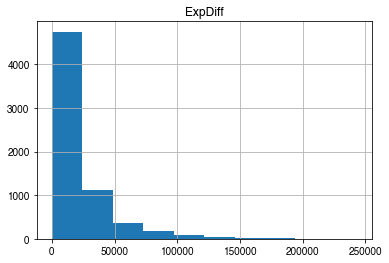

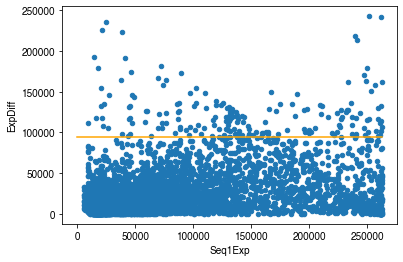

In [105]:
CurrentEditDist =2
Dist2DF =  MakeEditDistDF(CurrentEditDist)

In [106]:
test = stats.ks_2samp(Dist2DF.ExpDiff.values,holdActDeltas)
test

KstestResult(statistic=0.3360342675352219, pvalue=1.2935e-320)

KstestResult(statistic=0.3360342675352219, pvalue=1.2935e-320)

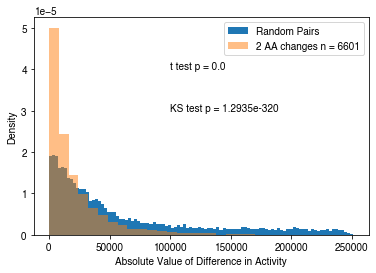

In [107]:
#overlay 2 AA changes with background distribution
plt.hist(holdActDeltas,100, density=True,label='Random Pairs')
plt.hist(Dist2DF.ExpDiff,30,alpha=.5, density=True,label='2 AA changes n = %i'%len(Dist2DF))
plt.legend()
test = stats.ttest_ind(Dist2DF.ExpDiff.values,holdActDeltas, equal_var=False)
plt.xlabel('Absolute Value of Difference in Activity'), plt.ylabel('Density')
plt.text(100000,4e-5,'t test p = %r'%test[1])
test = stats.ks_2samp(Dist2DF.ExpDiff.values,holdActDeltas)
plt.text(100000,3e-5,'KS test p = %r'%test[1])
plt.savefig('Figures/PaperFigs/Supp/PairwiseActivityChanges_2AA.pdf')
test

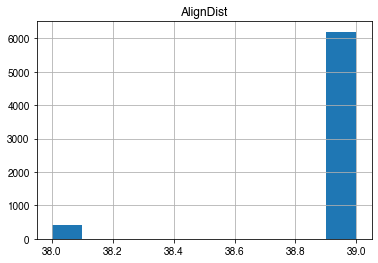

6198 pairs are offset by 1AA and have an alignment score of 39 and an edit distance of 2
403 pairs have 2 mismatches and have an alignment score of 38 and an edit distance of 2
Current Activity Threshold is: 94031 
Current Change in Activity Threshold is: 0.50 


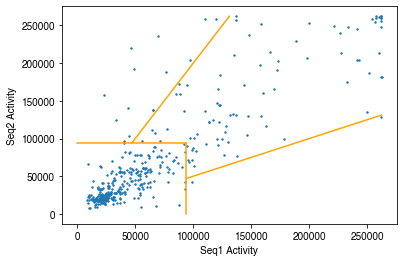

There are 13 point mutations that flip from active to inactive
There are 42 point mutations that cause a 50 percent drop in activity
There are 16 point mutations that cause a 50 percent drop in activity AND one is active
There are 28 point mutations that flip from active to inactive or cause a 50 percent drop in activity
(28, 10)

----------------------------------------

LSSTSCDTVQAFFDPSDAISTPSTGFISPSQEIQPSTTPC	 46211.04
               L   L                    	 174318.21	S>L
LSSTSCDTVQAFFDPLDAILTPSTGFISPSQEIQPSTTPC	 220529.24

AFFDPSDAISTPSTGFISPSQEIQPSTTPCNDFGVSPMFD	 69768.63
     L   L                              	 166437.10	S>L
AFFDPLDAILTPSTGFISPSQEIQPSTTPCNDFGVSPMFD	 236205.73

DDAVVESFFSSSTDSTPMFEYENAEDNSKEWTSAFDNDIP	 109836.54
                       L         L      	 148616.85	A>L
DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP	 258453.39

CDTVQAFFDPSDAISTPSTGFISPSQEIQPSTTPCNDFGV	 49006.78
          L   L                         	 143117.24	S>L
CDTVQAFFDPLDAILTPSTGFISPSQEIQPSTTPCND

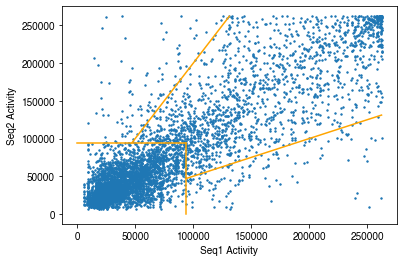

There are 261 point mutations that flip from active to inactive
There are 882 point mutations that cause a 50 percent drop in activity
There are 218 point mutations that cause a 50 percent drop in activity AND one is active
There are 384 point mutations that flip from active to inactive or cause a 50 percent drop in activity
(384, 10)

----------------------------------------

FSGNFSAAGESLFDLPTSTISPYDILNLQNVGLSAGASPD	 251748.19
.......................................	 242735.19
 SGNFSAAGESLFDLPTSTISPYDILNLQNVGLSAGASPDY	 9013.00

Higher activity Seq has a WFYLM at end
Higher activity Seq has a WFYLM at end

FSSPYLFDSPSEGYETSPLFGAEDTNGDNWYSLFPEVNQD	 261893.54
.......................................	 241272.86
 SSPYLFDSPSEGYETSPLFGAEDTNGDNWYSLFPEVNQDS	 20620.68

Higher activity Seq has a WFYLM at end
Higher activity Seq has a WFYLM at end

PEYHDNFDVSPFINNSDLDNALTGSAGDPWYPLFPPEEQM	 24513.44
.......................................	 236124.69
 EYHDNFDVSPFINNSDLDNALTGSAGDPWYPLFPPEEQMS	 260638

.......................................	 65307.13
 GTVSPQDLLRDPFASAPNSTAFTNLTSPDSQYHQSPEFAD	 64132.73

Higher activity Seq has a WFYLM at end
Higher activity Seq has a WFYLM at end

THTAIGLNQRRHSSHQLRQNLQGRVHLQQKHRLAQIQASG	 95190.78
.......................................	 65216.57
 HTAIGLNQRRHSSHQLRQNLQGRVHLQQKHRLAQIQASGS	 29974.21

DLLIQDPYMSAPNSTAFTALTSPSPFESPEYMDGYDVSPN	 42582.60
.......................................	 64987.17
 LLIQDPYMSAPNSTAFTALTSPSPFESPEYMDGYDVSPNF	 107569.77

Higher activity Seq has a WFYLM at end
Higher activity Seq has a WFYLM at end

 AFTNLTSPSTYNESPEWGVDDNFDVSPFVGNNNGDLDHAL	 131410.17
 .......................................	 64891.51
TAFTNLTSPSTYNESPEWGVDDNFDVSPFVGNNNGDLDHA	 66518.66

Higher activity Seq has a WFYLM at end

FDVSPNFAGSDFDAGGNDVWFPLFPQSNTQQNANVEHSPA	 135877.59
.......................................	 64875.35
 DVSPNFAGSDFDAGGNDVWFPLFPQSNTQQNANVEHSPAE	 71002.24

Higher activity Seq has a WFYLM at end
Higher activity Seq has a WFYLM at end



In [108]:
# for all seqs with Editdistance ==2 calculate an alignment score
tempScoresList =[]
for i, row in Dist2DF.iterrows():
    tempAlignmnet = pairwise2.align.localxx(row.Seq1,row.Seq2)
    tempScores =[]
    for alignment in tempAlignmnet: 
        tempScores.append(alignment[2])
    tempScoresList.append(max(tempScores))
    

Dist2DF['AlignDist'] = tempScoresList
Dist2DF.hist('AlignDist')
plt.show()
print('%i pairs are offset by 1AA and have an alignment score of 39 and an edit distance of 2'%sum(Dist2DF.AlignDist==39))
print('%i pairs have 2 mismatches and have an alignment score of 38 and an edit distance of 2'%sum(Dist2DF.AlignDist==38))

tempDF = Dist2DF[Dist2DF.AlignDist==38]
plotADpairs(tempDF)

tempDF = Dist2DF[Dist2DF.AlignDist==39]
plotADpairs(tempDF)

## ignore the handdesigned FF>AA mutant
print('delete one from counts to ignore the handdesigned FF>AA mutant')

# When Edit Distance ==3
390 have min(Editdist) =3

1379 pairs have Editdist =3

989 have an Edidist of 3 and something else closer

Note controls are still included here. Eventually they will cause problems. 



In [70]:
if False:
    CurrentEditDist =3
    Dist3DF =  MakeEditDistDF(CurrentEditDist)
    
    
    # for all seqs with Editdistance ==3 calculate an alignment score
    tempScoresList =[]
    for i, row in Dist3DF.iterrows():
        tempAlignmnet = pairwise2.align.localxx(row.Seq1,row.Seq2)
        tempScores =[]
        for alignment in tempAlignmnet: 
            tempScores.append(alignment[2])
        tempScoresList.append(max(tempScores))

    Dist3DF['AlignDist'] = tempScoresList
    Dist3DF.hist('AlignDist')
    plt.show()
    print('%i pairs are offset and/or have mismatches and have an alignment score of 38 and an edit distance of 3'%sum(Dist3DF.AlignDist==38))
    print('%i pairs have 3 mismatches and have an alignment score of 37 and an edit distance of 3'%sum(Dist3DF.AlignDist==37))

    # tempDF = Dist3DF[Dist3DF.AlignDist==38]
    # plotADpairs(tempDF)
    tempDF = Dist3DF[Dist3DF.AlignDist==37]
    plotADpairs(tempDF)



In [ ]:
# x,y=[],[]
# for seq in Seqlist[1:]:
#     x.append(mindists[seq])
#     y.append(minExpDiffs[seq])
# plt.scatter(x,y,s=1)
# corr = scipy.stats.pearsonr(x,y)
# plt.title(corr[0])
# # plt.plot([0,31],[meanRandDiff,meanRandDiff])
# plt.show()


# len(mindists)
# # mindists
# # minExpDiffs


# tempDF  = masterDF[masterDF.Recovered]
# #calculate the random distance expectation
# tempSeries = tempDF[Activity]
# randDiffs =[]
# for i in range(10000):
#     a,b = tempSeries.sample(n=2, replace=False)
#     randDiffs.append(np.abs(a-b))
    
# meanRandDiff = np.mean(randDiffs)

# tempDF.plot.scatter(x='MinEditDist', y='MinExpDiff' )
# plt.plot([0,31],[meanRandDiff,meanRandDiff])
# plt.show()

# sns.boxplot(x='MinEditDist', y='MinExpDiff',data=tempDF)
# plt.plot([0,31],[meanRandDiff,meanRandDiff])
# plt.show()
# for i in [1,2,3,4]:
#     indx = masterDF.Recovered &(masterDF.MinEditDist==i)
#     tempDF = masterDF[indx]
#     plt.subplot(2,2,i)
#     plt.hist(randDiffs,40,density=True)
#     plt.hist(tempDF.MinExpDiff,40,alpha=.4,density=1)
# #     plt.plot([meanRandDiff,meanRandDiff],[0,3])
#     plt.title('Edit Distance = %i (n = %i)'%(i,sum(indx)))
# plt.xlabel('Activity Difference'),plt.tight_layout()
# plt.show()
# len(mindists)

# define S cer as Reference

In [38]:
# Define the Scer WT for comparison
indx = (Orthologs_DF.SpeciesNames =='Saccharomycotina_sp|P03069|GCN4_YEAST')&(Orthologs_DF.Activity>0)
ScertempDF = Orthologs_DF[indx]
ScertempDF = ScertempDF.sort_values(by='NativeLocation',ascending=True)
for i,row in ScertempDF.iterrows():
#     print(row)
    print(row.Seq)
    print(row.Activity)
    print(row.NativeLocation)
# ScertempDF[:6]
ScertempDF.to_csv('Figures/Scer_WT_Data.csv')
WTactivity = dict(zip(ScertempDF.Seq,ScertempDF.Activity))


MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMV
46403.65592043848
20
PSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIF
73303.81603515925
25
LNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFDKFIK
37736.426679898126
30
FSPLDGSKSTNENVSASTSTAKPMVGQLIFDKFIKTEEDP
25037.654330000863
35
GSKSTNENVSASTSTAKPMVGQLIFDKFIKTEEDPIIKQD
23214.414723588103
40
NENVSASTSTAKPMVGQLIFDKFIKTEEDPIIKQDTPSNL
18010.960469063073
45
ASTSTAKPMVGQLIFDKFIKTEEDPIIKQDTPSNLDFDFA
56179.84649307876
50
AKPMVGQLIFDKFIKTEEDPIIKQDTPSNLDFDFALPQTA
72657.87928873052
55
GQLIFDKFIKTEEDPIIKQDTPSNLDFDFALPQTATAPDA
36423.29803601011
60
DKFIKTEEDPIIKQDTPSNLDFDFALPQTATAPDAKTVLP
21009.182223446354
65
TEEDPIIKQDTPSNLDFDFALPQTATAPDAKTVLPIPELD
9013.0
70
IIKQDTPSNLDFDFALPQTATAPDAKTVLPIPELDDAVVE
32461.80907189322
75
TPSNLDFDFALPQTATAPDAKTVLPIPELDDAVVESFFSS
230494.9529698572
80
DFDFALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDST
176811.3783434669
85
LPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEY
165871.31493035454
90
TAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLED
140557.40047565952
95
KTVLPIPELDDA

In [39]:
ScertempDF
CAAD = 'STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK'
print(WTactivity[CAAD])

137976.9357086746


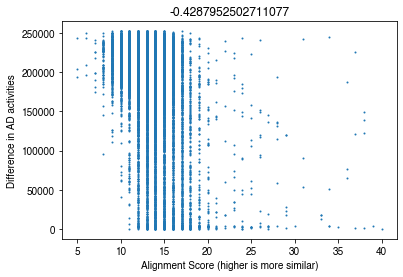

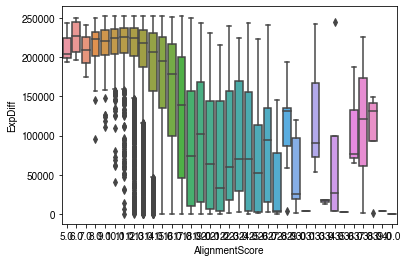

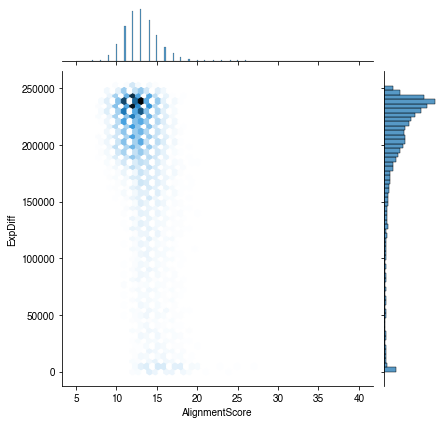

144.83 sec


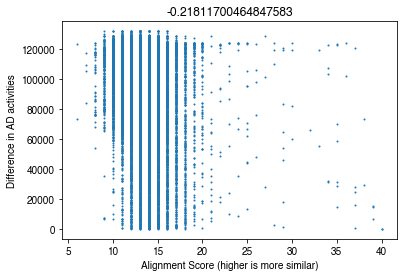

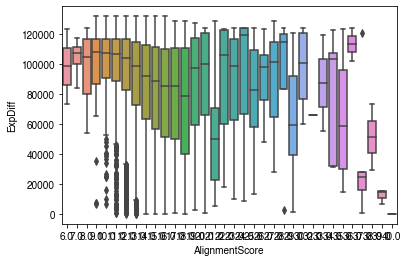

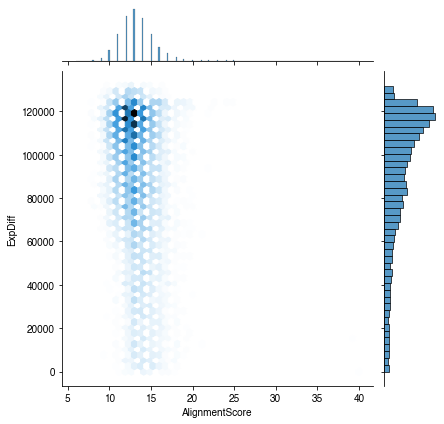

146.15 sec


[Alignment(seqA='STDSTP-MFEYEN--LEDNSKEWTSLFDNDIP-VTTDDVSLADK', seqB='NTDST-HMFEY--WALEDNSKEWTSLFDNDI-WVTTDDVSLADK', score=35.0, start=1, end=44),
 Alignment(seqA='STDSTPMFEYEN--LEDNSKEWTSLFDNDIP-VTTDDVSLADK', seqB='NTDSTHMFEY--WALEDNSKEWTSLFDNDI-WVTTDDVSLADK', score=35.0, start=1, end=43),
 Alignment(seqA='STDSTP-MFEYEN-LEDNSKEWTSLFDNDIP-VTTDDVSLADK', seqB='NTDST-HMFEY-WALEDNSKEWTSLFDNDI-WVTTDDVSLADK', score=35.0, start=1, end=43),
 Alignment(seqA='STDSTPMFEYEN-LEDNSKEWTSLFDNDIP-VTTDDVSLADK', seqB='NTDSTHMFEY-WALEDNSKEWTSLFDNDI-WVTTDDVSLADK', score=35.0, start=1, end=42),
 Alignment(seqA='STDSTP-MFEYEN-LEDNSKEWTSLFDNDIP-VTTDDVSLADK', seqB='NTDST-HMFEYW-ALEDNSKEWTSLFDNDI-WVTTDDVSLADK', score=35.0, start=1, end=43),
 Alignment(seqA='STDSTPMFEYEN-LEDNSKEWTSLFDNDIP-VTTDDVSLADK', seqB='NTDSTHMFEYW-ALEDNSKEWTSLFDNDI-WVTTDDVSLADK', score=35.0, start=1, end=42),
 Alignment(seqA='STDSTP-MFEYE-NLEDNSKEWTSLFDNDIP-VTTDDVSLADK', seqB='NTDST-HMFEY-WALEDNSKEWTSLFDNDI-WVTTDDVSLADK', score=35.0, start

In [40]:
# alignment distance vs activity difference 
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import time
MaxAlignScore ={}
MaxAlignScoreExpDiff = {}
tempDF = masterDF[masterDF.Recovered]
Seqlist = tempDF.ADseq.values
Seqlist_Scer = ScertempDF[:8].Seq.values
# Seqlist_Scer =['DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP']
altGCN4= 'DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP'
Seqlist_Scer =[altGCN4,CAAD]

ActDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
for i, seq1 in enumerate(Seqlist_Scer):
    tempScores2 = []
    expdists = []
    tic = time.perf_counter()
    for j, seq2 in enumerate(Seqlist):
        #remove alignment to self
#         if seq1 != seq2:
        tempAlignmnet = pairwise2.align.localxx(seq1,seq2)
        tempScores =[]
        for alignment in tempAlignmnet: 
            tempScores.append(alignment[2])
        tempScores2.append(max(tempScores))
        expdists.append(np.abs(ActDict[seq1]-ActDict[seq2]))
#     print(seq1)
    plt.scatter(tempScores2,expdists,s=1)
    corr = scipy.stats.pearsonr(tempScores2,expdists)
    plt.title(corr[0])
    plt.xlabel('Alignment Score (higher is more similar)')
    plt.ylabel('Difference in AD activities')
    plt.show()

    miniDF = pd.DataFrame({'ADseq':Seqlist,'AlignmentScore':tempScores2,'ExpDiff':expdists})
    sns.boxplot(data=miniDF,x='AlignmentScore',y='ExpDiff')
    plt.show()
    sns.jointplot(data=miniDF,x='AlignmentScore',y='ExpDiff',kind='hex')
    plt.show()
#     indx = max(tempScores2)==tempScores2
#     MaxAlignScore[seq1] =tempScores2[indx]
#     MaxAlignScoreExpDiff[seq1] = (expdists[indx])
    toc = time.perf_counter()
    print("%.2f sec" %(toc - tic))
#add to DF
tempSeries = masterDF.ADseq
masterDF['MaxAlignScore']= tempSeries.map(MaxAlignScore)
masterDF['MaxAlignScoreExpDiff']= tempSeries.map(MaxAlignScoreExpDiff)
tempAlignmnet

# ActDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
# for i, seq1 in enumerate(Seqlist):
#     tempScores2 = []
#     expdists = []
#     for j, seq2 in enumerate(Seqlist):
#         if i>j:
#             tempAlignmnet = pairwise2.align.localxx(seq1,seq2)
#             tempScores =[]
#             for alignment in tempAlignmnet: 
#                 tempScores.append(alignment[2])
# #             print(tempScores)
#             tempScores2.append(max(tempScores))
#             expdists.append(np.abs(ActDict[seq1]-ActDict[seq2]))
#     if i>0:
#         indx = max(tempScores2)==tempScores2
#         MaxAlignScore[seq1] =tempScores2[indx]
#         MaxAlignScoreExpDiff[seq1] = (expdists[indx])
# #add to DF
# tempSeries = masterDF.ADseq
# masterDF['MaxAlignScore']= tempSeries.map(MaxAlignScore)
# masterDF['MaxAlignScoreExpDiff']= tempSeries.map(MaxAlignScoreExpDiff)
# tempAlignmnet
# tempScores
# MaxAlignScore

In [41]:
print(len(Seqlist))
print(len(tempScores2))
len(expdists)

18947
18947


18947

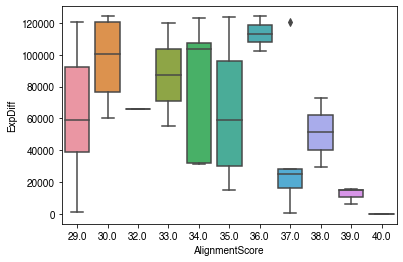

,ADseq,AlignmentScore,ExpDiff
15495,DAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPV,30.0,124020.292878
15496,SFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDV,35.0,69806.843858
15497,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,40.0,0.000000
15498,PMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIEST,35.0,31058.382228
15499,ENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEVSL,30.0,81715.957546
17001,AAVVESFFSSSADSTPMFEYENLEDNSKEWTSLFDNDIPV,29.0,119478.182083
17002,SFFSSSADSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDV,34.0,107537.425426
17003,SADSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,39.0,6318.721835
17004,ENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEISL,30.0,60194.013769
17044,AAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPV,30.0,119570.191966


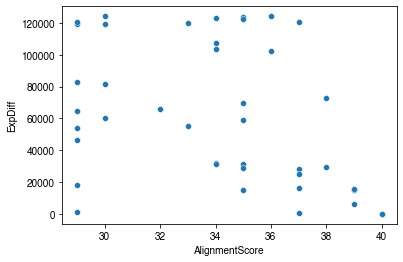

In [42]:
import YeastAnalysisfunctions as YAF

ExpDeltaThesh = 100000
AligmentScoreThresh = 28
indx = miniDF.AlignmentScore>AligmentScoreThresh
tempDF = miniDF[indx]
sns.boxplot(data=tempDF,x='AlignmentScore',y='ExpDiff')
plt.show()
sns.scatterplot(data=tempDF,x='AlignmentScore',y='ExpDiff')

indx = miniDF.AlignmentScore>AligmentScoreThresh
tempDF = miniDF[indx]
# visualize_AA_Changes(tempDF,altGCN4,'temp',color='r',colname='ADseq')
tempDF

# Repeat with edit distance to altGcn4

In [43]:
# using the altGcn4 AD as a reference
# find the Alisngment distance to all other tiles
# plot Delta activity vs all alignment distance
# Zoom into tiles with no change in activiyt
# zoom into changes with large changes in activity

In [44]:
altGCN4= 'DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP'
Seqlist_Scer =[altGCN4]

def calcEditDist(seq1,colname):
    mindists ={}
    minExpDiffs = {}
    tempDF = masterDF#[masterDF.Recovered]
    Seqlist = tempDF.ADseq.values
    AlignmentDists = np.zeros((len(Seqlist),len(Seqlist)))
    print (AlignmentDists.shape)
    ActDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
    tempdists = []
    expdists = []
    for j, seq2 in enumerate(Seqlist):
        tempDist =editdistance.eval(seq1,seq2)
        tempdists.append(tempDist)
        expdists.append(np.abs(ActDict[seq1]-ActDict[seq2]))
        AlignmentDists[i,j]=tempDist
    if i>0:
        indx = min(tempdists)==tempdists
        mindists[seq1] =(min(tempdists))
        minExpDiffs[seq1] = (expdists[indx])

    tempSeries = masterDF.ADseq
    masterDF['EditDist_to_'+colname]= tempdists#tempSeries.map(mindists)
    masterDF['ExpDiff_to_'+colname]= expdists# tempSeries.map(minExpDiffs)
    
calcEditDist(altGCN4,'AltGcn4')
calcEditDist(CAAD,'CAAD')

(20731, 20731)
(20731, 20731)


In [45]:
def visualize_AA_Changes_v3(AD_DF,WT,plotname,color='r',ypos=0,printWT =False,colname='shortname',printname=True):
    fontsize=18
    # print WT  
    #plot dimentions
    left, width = 0.1, 0.25
    bottom, height = 0.05, 0.3
    spacing = 0.07
    horizontalspacing = 0.02
    middlecorrection =.09
    toppanelheight = .54
    
    fig = plt.figure(figsize=(.9,.9)) 
    ax = fig.add_axes([left+width+horizontalspacing,toppanelheight,width,height])

    if printWT ==True:
        for pos, ADaa in enumerate(WT):
            ax.text(pos,ypos, ADaa, color='k',fontsize=fontsize, fontweight='bold', family='monospace')
        plt.text(pos+1,ypos,'%.1f     WT'%WTactivity[WT],fontsize=fontsize)
        ypos-=1        
        # for each variant
    for j,entry in AD_DF.iterrows():
        AD = entry.ADseq
        for pos, ADaa in enumerate(AD):
            if ADaa == WT[pos]:
                # print AA in gray if it is WT
                ax.text(pos,ypos, ADaa, color='lightgray',fontsize=fontsize, family='monospace')
            else:
                # print AA in color if it is NOT WT
                ax.text(pos,ypos, ADaa, color=color,fontsize=fontsize, fontweight='bold', family='monospace')
        plt.text(pos+1,ypos,'%.1f     %s'%(entry[Activity],entry['Name']),fontsize=fontsize)

        ypos-=1
    
     
# visualize_AA_Changes_v3(tempDF,RefSeqDict[colname],colname,ypos=0,color='r',printWT=True,printname=True)
#     plt.savefig('ExportedSeqLists/EditDistComparisons/%s_SmallSeqChanges.pdf'%(colname))
# plt.show()

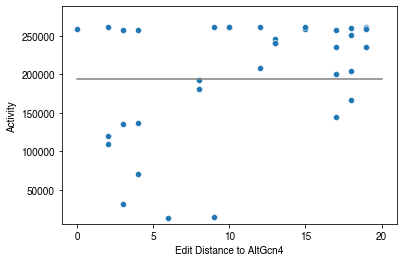

<Figure size 64.8x64.8 with 0 Axes>

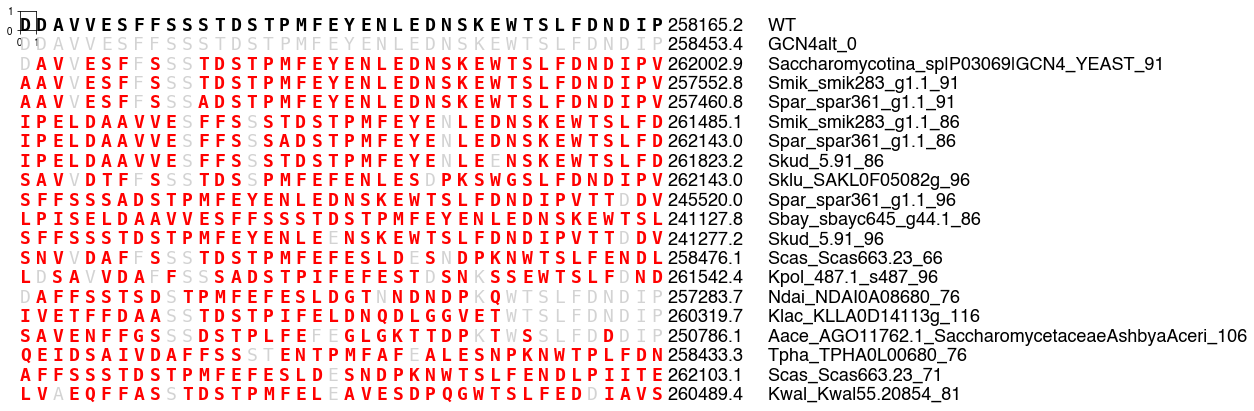

                                                    Name  Activity_SCglucose  \
20687                                          GCN4alt_0       258453.390222   
16978           Saccharomycotina_sp|P03069|GCN4_YEAST_91       262002.863007   
18654                               Smik_smik283_g1.1_91       257552.762096   
18605                               Spar_spar361_g1.1_91       257460.752213   
18653                               Smik_smik283_g1.1_86       261485.120406   
18604                               Spar_spar361_g1.1_86       262143.000000   
19500                                       Skud_5.91_86       261823.156437   
18952                               Sklu_SAKL0F05082g_96       262143.000000   
18606                               Spar_spar361_g1.1_96       245519.995556   
18690                             Sbay_sbayc645_g44.1_86       241127.809066   
19502                                       Skud_5.91_96       241277.248980   
18792                                 Sc

<Figure size 64.8x64.8 with 0 Axes>

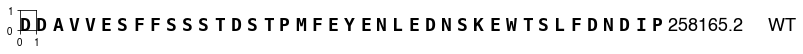

Empty DataFrame
Columns: [Name, Activity_SCglucose, EditDist_to_AltGcn4]
Index: []


<Figure size 64.8x64.8 with 0 Axes>

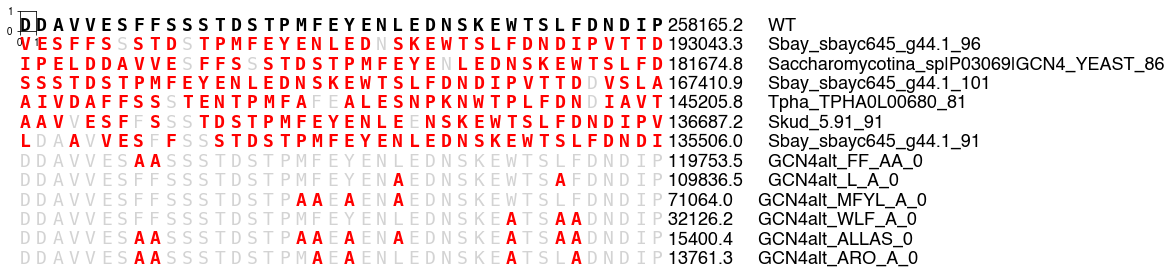

                                           Name  Activity_SCglucose  \
18692                    Sbay_sbayc645_g44.1_96       193043.297482   
16977  Saccharomycotina_sp|P03069|GCN4_YEAST_86       181674.784117   
18693                   Sbay_sbayc645_g44.1_101       167410.937504   
19761                       Tpha_TPHA0L00680_81       145205.773354   
19501                              Skud_5.91_91       136687.193385   
18691                    Sbay_sbayc645_g44.1_91       135506.011094   
20688                           GCN4alt_FF_AA_0       119753.509231   
20693                             GCN4alt_L_A_0       109836.536324   
20689                          GCN4alt_MFYL_A_0        71064.009720   
20690                           GCN4alt_WLF_A_0        32126.202553   
20691                           GCN4alt_ALLAS_0        15400.437967   
20692                           GCN4alt_ARO_A_0        13761.263345   

       EditDist_to_AltGcn4  
18692                    8  
16977             

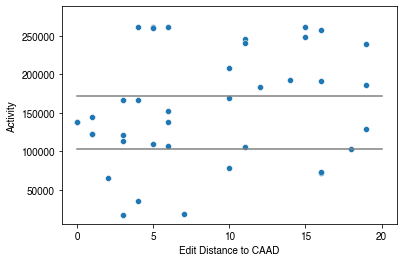

<Figure size 64.8x64.8 with 0 Axes>

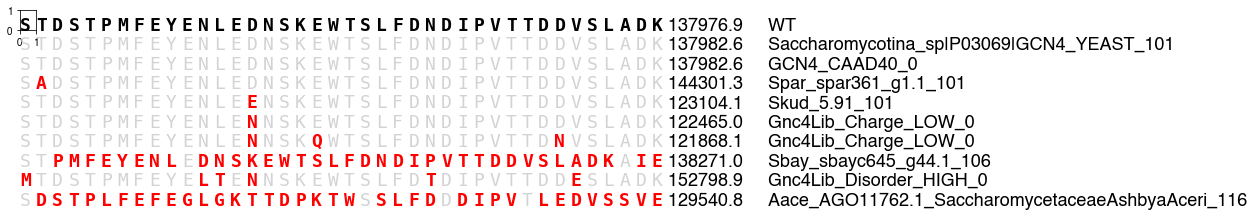

                                                    Name  Activity_SCglucose  \
16980          Saccharomycotina_sp|P03069|GCN4_YEAST_101       137982.570130   
20682                                      GCN4_CAAD40_0       137982.570130   
18607                              Spar_spar361_g1.1_101       144301.291965   
19503                                      Skud_5.91_101       123104.135464   
20711                               Gnc4Lib_Charge_LOW_0       122464.996923   
20713                               Gnc4Lib_Charge_LOW_0       121868.094214   
18694                            Sbay_sbayc645_g44.1_106       138270.965613   
20728                            Gnc4Lib_Disorder_HIGH_0       152798.870307   
20314  Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri_116       129540.750244   

       EditDist_to_CAAD  
16980                 0  
20682                 0  
18607                 1  
19503                 1  
20711                 1  
20713                 3  
18694            

<Figure size 64.8x64.8 with 0 Axes>

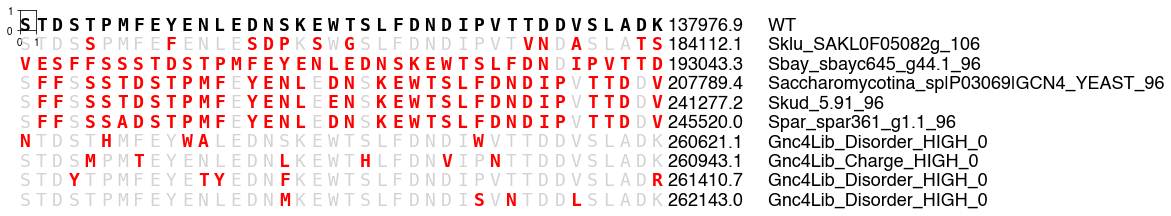

                                           Name  Activity_SCglucose  \
18954                     Sklu_SAKL0F05082g_106       184112.058313   
18692                    Sbay_sbayc645_g44.1_96       193043.297482   
16979  Saccharomycotina_sp|P03069|GCN4_YEAST_96       207789.413988   
19502                              Skud_5.91_96       241277.248980   
18606                      Spar_spar361_g1.1_96       245519.995556   
20730                   Gnc4Lib_Disorder_HIGH_0       260621.088791   
20721                     Gnc4Lib_Charge_HIGH_0       260943.132945   
20727                   Gnc4Lib_Disorder_HIGH_0       261410.705323   
20722                   Gnc4Lib_Disorder_HIGH_0       262143.000000   

       EditDist_to_CAAD  
18954                12  
18692                14  
16979                10  
19502                11  
18606                11  
20730                 5  
20721                 6  
20727                 5  
20722                 4  


<Figure size 64.8x64.8 with 0 Axes>

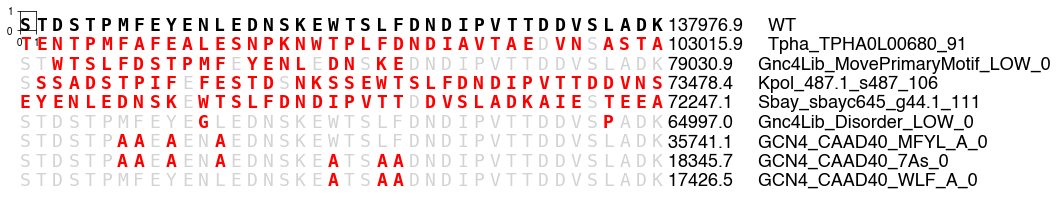

                                 Name  Activity_SCglucose  EditDist_to_CAAD
19763             Tpha_TPHA0L00680_91       103015.907274                18
20716  Gnc4Lib_MovePrimaryMotif_LOW_0        79030.855049                10
19813             Kpol_487.1_s487_106        73478.448935                16
18695         Sbay_sbayc645_g44.1_111        72247.106483                16
20712          Gnc4Lib_Disorder_LOW_0        64997.041479                 2
20684            GCN4_CAAD40_MFYL_A_0        35741.083274                 4
20685               GCN4_CAAD40_7As_0        18345.739700                 7
20683             GCN4_CAAD40_WLF_A_0        17426.515045                 3


In [111]:

RefSeqDict = {'AltGcn4':altGCN4,'CAAD':CAAD}
ExpDeltaTheshLow =  {'AltGcn4':20000,'CAAD':20000}
ExpDeltaTheshHigh =   {'AltGcn4':100000,'CAAD':20000}
EdiDistThresh = 20

for colname in ['AltGcn4','CAAD']:
    Xval = 'EditDist_to_'+colname
    Yval = 'ExpDiff_to_'+colname
    indx = masterDF.Recovered & (masterDF[Xval]<EdiDistThresh)
    tempDF =masterDF[indx]

    sns.scatterplot(data=tempDF,x=Xval,y=Activity)
    plt.xticks([0,5,10,15,20])
    yval = ActDict[RefSeqDict[colname]]*1.25
    plt.plot([0,EdiDistThresh],[yval,yval],c='gray')
    yval = ActDict[RefSeqDict[colname]]*.75
    plt.plot([0,EdiDistThresh],[yval,yval],c='gray')
    plt.ylabel('Activity'), plt.xlabel('Edit Distance to %s'%colname)
    plt.savefig('ExportedSeqLists/EditDistComparisons/EditDistvsActivity_%s.pdf'%colname)
    plt.ylim([minActivity,maxActivity*1.1])
    plt.show()
    
    #small change in Seq AND small change in activity
    indx = masterDF.Recovered & (masterDF[Xval]<EdiDistThresh) & (masterDF[Yval]<ExpDeltaTheshLow[colname])
    tempDF = masterDF[indx]
    tempDF = tempDF.sort_values(by = Xval,ascending=True)
    protfasta.write_fasta(dict(zip(tempDF.Name,tempDF.ADseq)),
                          'ExportedSeqLists/EditDistComparisons/%s_SmallSeqChange_SmallExpChange.fasta'%colname)
        # show the annotated sequences
    fig = plt.figure(figsize=(.9,.9))  
    visualize_AA_Changes_v3(tempDF,RefSeqDict[colname],colname,ypos=0,color='r',printWT=True,printname=True)
    plt.savefig('ExportedSeqLists/EditDistComparisons/%s_SmallSeqChange_SmallExpChange.pdf'%(colname))
    plt.show()
    print(tempDF[['Name',Activity,Xval]])

    
    #small change in Seq AND large INCREASE in activity
    indx = masterDF.Recovered & (masterDF[Xval]<15) & (masterDF[Activity]>ActDict[RefSeqDict[colname]]*1.25)
    tempDF = masterDF[indx]
    tempDF = tempDF.sort_values(by = Yval,ascending=True)
    protfasta.write_fasta(dict(zip(tempDF.Name,tempDF.ADseq)),
                          'ExportedSeqLists/EditDistComparisons/%s_SmallSeqChange_LargeExpChange.fasta'%colname)
        # show the annotated sequences
    fig = plt.figure(figsize=(.9,.9))  
    visualize_AA_Changes_v3(tempDF,RefSeqDict[colname],colname,ypos=0,color='r',printWT=True,printname=True)
    plt.savefig('ExportedSeqLists/EditDistComparisons/%s_SmallSeqChange_LargeExpINCREASE.pdf'%(colname))
    plt.show()
    print(tempDF[['Name',Activity,Xval]])


    #small change in Seq large change DECREASE in activity
    indx = masterDF.Recovered & (masterDF[Xval]<EdiDistThresh) & (masterDF[Activity]<ActDict[RefSeqDict[colname]]*0.75)
    tempDF = masterDF[indx]
    tempDF = tempDF.sort_values(by = Yval,ascending=True)
    protfasta.write_fasta(dict(zip(tempDF.Name,tempDF.ADseq)),
                          'ExportedSeqLists/EditDistComparisons/%s_SmallSeqChangeLargeExpChange_MOD3.fasta'%colname)
    fig = plt.figure(figsize=(.9,.9))  
    visualize_AA_Changes_v3(tempDF,RefSeqDict[colname],colname,ypos=0,color='r',printWT=True,printname=True)
    plt.savefig('ExportedSeqLists/EditDistComparisons/%s_SmallSeqChange_LargeExpDECREASE.pdf'%(colname))
    plt.show()

    print(tempDF[['Name',Activity,Xval]])


In [47]:
# repeat alignment distances with most literal ortholog
def FindLiteralAlignmentTile(Location=1,distcutoff=5):
    HoldSeqs,HoldNames,HoldNormLocation =[],[],[]
    for species in set(Orthologs_DF.SpeciesNames):
        indx = (Orthologs_DF.SpeciesNames==species)&(Orthologs_DF.Activity>0)
        tempDF =Orthologs_DF[indx]
        if sum(tempDF.NormLocation==Location)==1:
            indx2 = tempDF.NormLocation==Location
            tempDF2 = tempDF[indx2]
            HoldSeqs.append(tempDF2.Seq.values[0])
            HoldNames.append(tempDF2.SpeciesNames.values[0])
            HoldNormLocation.append(1)
        else:
            posDiff = min(abs((tempDF.NormLocation)-Location))
            if posDiff <distcutoff:
                indx2 = abs((tempDF.NormLocation)-Location)==posDiff 
                tempDF2 = tempDF[indx2]
                if len(tempDF2.Seq.values)>0:
                    HoldSeqs.append(tempDF2.Seq.values[0])
                    HoldNames.append(tempDF2.SpeciesNames.values[0])
                    HoldNormLocation.append(posDiff)

    ExportDF = pd.DataFrame({"SpeciesNames":HoldNames,'Seq':HoldSeqs,'NormLocation':HoldNormLocation})
    print('Found %i "Literal" ortholog tiles less than %i away'%(len(ClosestSeqs),distcutoff))
    return ExportDF
ClosestSeqs = FindLiteralAlignmentTile()


NameError: name 'ClosestSeqs' is not defined

In [ ]:
ClosestSeqs[:10]
ClosestSeqs.hist('NormLocation')
set(ClosestSeqs.NormLocation)
ClosestSeqs

In [48]:
def calcEditDist2(RefSeq,colname,InputDF):
    tempdists,expdists,ActivityValues = [],[],[]
    ActDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
    for j, row in InputDF.iterrows():
        tempSeq = str(row.Seq)
        tempDist = editdistance.eval(RefSeq,tempSeq)
        tempdists.append(tempDist)
        expdists.append(np.abs(ActDict[RefSeq]-ActDict[tempSeq]))
        ActivityValues.append(ActDict[tempSeq])
    InputDF['EditDist_to_'+colname]= tempdists#tempSeries.map(mindists)
    InputDF['ExpDiff_to_'+colname]= expdists#
    InputDF['Activity']=ActivityValues
    
    plt.scatter(tempdists,expdists)
    plt.ylabel('Activity Difference'),plt.xlabel('Edit Distance to '+colname)
    plt.xlim([-1,40]),plt.xticks([0,10,20,30])
    plt.show()
    plt.scatter(tempdists,ActivityValues)
    plt.ylabel('Activity'),plt.xlabel('Edit Distance to '+colname),plt.xlim([-1,40]),plt.xticks([0,10,20,30])
    plt.savefig('ExportedSeqLists/EditDistComparisons/LiteralTileOrthologs_%s.pdf'%colname)
    plt.show()
    plt.hist(tempdists)
    print('There are %i Orthologs with a position matched region to the %s with edit distance <21'
          %(sum(InputDF['EditDist_to_'+colname]<21),colname))

calcEditDist2(CAAD,'CAAD',ClosestSeqs)


NameError: name 'ClosestSeqs' is not defined

In [49]:
ClosestSeqsAltCAAD = FindLiteralAlignmentTile(-20)
calcEditDist2(altGCN4,'AltCAAD',ClosestSeqsAltCAAD)


NameError: name 'ClosestSeqs' is not defined

In [50]:
indx = (Orthologs_DF.Seq==CAAD)
Orthologs_DF[indx]
editdistance.eval(CAAD,'PFINNSDLDNALTGSAGDPWYPLFPPEEQMSAPPKKDEES')

37

In [51]:
indx = (Orthologs_DF.Seq==altGCN4)
Orthologs_DF[indx]

,Unnamed: 0,SpeciesNames,NativeLocation,NormLocation,Seq,Activity,Stdev_BioReps,W..LF
80735,80735,Saccharomycotina_sp|P03069|GCN4_YEAST,109,-10,DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP,258165.206637,2420.034399,1


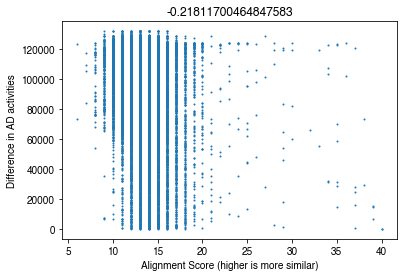

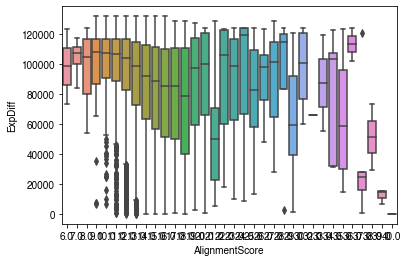

In [52]:
plt.scatter(tempScores2,expdists,s=1)
corr = scipy.stats.pearsonr(tempScores2,expdists)
plt.title(corr[0])
plt.xlabel('Alignment Score (higher is more similar)')
plt.ylabel('Difference in AD activities')
plt.show()

miniDF = pd.DataFrame({'ADseq':Seqlist,'AlignmentScore':tempScores2,'ExpDiff':expdists})
sns.boxplot(data=miniDF,x='AlignmentScore',y='ExpDiff')
plt.show()

In [53]:
indx = ((FullOrthoDF.SpeciesName=='Anig_EHA26660.1_AspergillusNigerATCC1015')|
        (FullOrthoDF.SpeciesName=='Afla_EED46972.1_AspergillusFlavusNRRL3357')|
    (FullOrthoDF.SpeciesName=='Nfis_EAW24893.1_NeosartoryaFischeriNRRL181'))
tempDF = FullOrthoDF[indx]

exportfilename = 'ExportedSeqLists/PotentialTurnover.fasta'
tempDict = dict(zip(tempDF.SpeciesName,tempDF.Seq))
protfasta.write_fasta(tempDict,exportfilename)